# Files needed

* `Plenum/style.mplstyle`
* `Plenum/resources/point-source_discovery_time-evolution.csv`
* `Plenum/resources/ngc_paper_68_contour.txt`
* `Plenum/resources/ngc_contour_spl.csv`
* `Plenum/resources/local_background_ngc.txt`
* `Plenum/resources/background_events_baseline.txt`
* `Plenum/resources/background_events_improved.txt`
* `Plenum/resources/PL_events_baseline.txt`
* `Plenum/resources/PL_events_improved.txt`
* `Plenum/resources/PLC_events_baseline.txt`
* `Plenum/resources/PLC_events_improved.txt`


In [26]:
%run ../../core/event_numbers.py

Calculate detection efficiencies
Calculate instantaneous detection efficiencies


3it [00:02,  1.47it/s]


# Import & settings

In [1]:
import sys
sys.path.insert(0, "../../core/")

from os.path import join
from collections import namedtuple
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pickle import load
from scipy.stats import chi2

# PLEnuM tools
import settings as st
from tools import get_mids
from fluxes import ngc_flux, ngc_cut_flux, PL_flux, PLcut_flux, power_law, cut_off
# from fluxes import ngc_flux,PL_flux, PLcut_flux, power_law, cut_off#, ngc_cut_flux, 
from aeff_calculations import get_aeff_and_binnings

# plot settings
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plt.style.use("../../style.mplstyle")

plot_path = "plots/ngc_paper"
#plot_path = "plots/paper"
from matplotlib.colors import LogNorm, ListedColormap
import pickle
from matplotlib.gridspec import GridSpec
from fluxes import kheirandish_src_flux, inoue_src_flux

In [3]:
###### See plenum_skymap_illustrations_for_paper.ipynb for Skymaps #####

In [2]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(
    "../../resources/ngc_paper_68_contour.txt"
)
phi_c_68 /= 1e11

In [3]:
IC_North_det = "KM3NeT"

# flux models overview


In [3]:
font_color = "0.35"

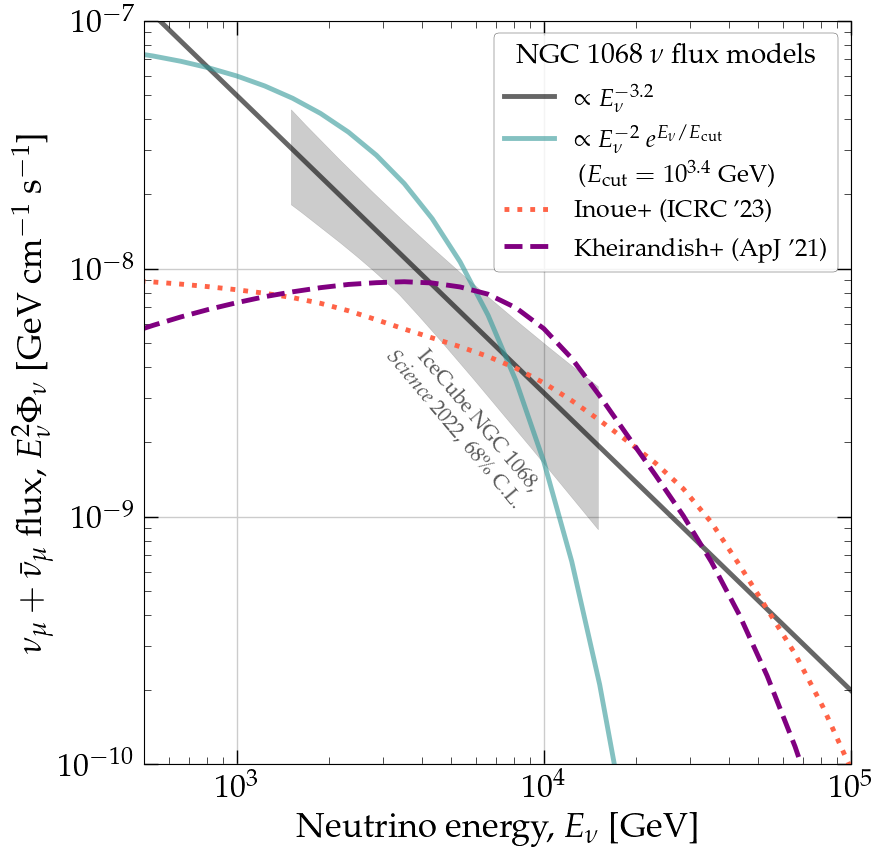

In [21]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

# pl = power_law(x_evals, ngc_pl0_flux.E0, ngc_pl0_flux.gamma, ngc_pl0_flux.norm)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, ax = plt.subplots(figsize=(9, 9))
fontsize = 25
# ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, st.E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"$\propto E_\nu^{{-{st.GAMMA_NGC}}}$",
    color="k",
    alpha=0.6,
    lw=3.5,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    # label=rf"PL $\gamma=${st.Gamma_cut}"
    # + rf"$\times$ cut-off "
    # + "\n"
    # + rf"($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    label=r"\hspace*{-1.5em}$\propto E_\nu^{-2}~e^{E_\nu/E_{\rm cut}}$"
    + r"\\[0.2em]"
    + rf"\hspace*{{-0.5em}}($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut}}}$ GeV)",
    color="#339999",
    alpha=0.6,
    lw=3.5,
)

ax.set_yscale("log")
# ax.set_ylabel(
#     r"$E^2 {\rm d}\Phi_{\nu_\mu + \bar{\nu}_\mu} / {\rm d}E$ [GeV / cm² s]", fontsize=fontsize
# )
ax.set_ylabel(
    r"$\nu_\mu+\bar{\nu}_\mu$ flux,~$E_\nu^2 \Phi_\nu$ " + r"[GeV~cm$^{-1}$~s$^{-1}$]",
    fontsize=fontsize,
)

ax.set_xscale("log")
ax.set_xlabel(r"Neutrino energy, $E_{\nu}$ [GeV]", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-7)
ax.set_xlim(5e2, 1e5)


ax.plot(
    x_evals,
    10 ** (inoue_src_flux.model_spline(np.log10(x_evals))) * (x_evals**y_scaling),
    color="tomato",
    ls=":",
    label="Inoue+ (ICRC '23)",
    lw=3.5,
)

ax.plot(
    x_evals,
    10 ** (kheirandish_src_flux.model_spline(np.log10(x_evals))) * (x_evals**y_scaling),
    color="purple",
    ls="--",
    label="Kheirandish+ (ApJ '21)",
    lw=3.5,
)

l = ax.legend(
    frameon=True,
    loc="upper right",
    ncols=1,
    # bbox_to_anchor=(-0.15, 1.4),
    columnspacing=0.8,
    edgecolor="k",
    title=r"NGC 1068 $\nu$ flux models",
)
plt.setp(l.get_title(), fontsize="x-large")

ax.annotate(
    r"IceCube NGC 1068," + "\n" + r"{\it Science} 2022, 68\%~C.L.",
    xy=(0.565, 0.46),
    xycoords="axes fraction",
    ha="right",
    va="center",
    zorder=10,
    color=font_color,
    fontsize=15, 
    rotation=-50
)

ax.tick_params(axis='both', which='major', labelsize=23)

f.savefig(join(st.BASEPATH, plot_path, "model_source_fluxes.pdf"), bbox_inches="tight")

# Atmospheric background flux

In [69]:
with open(join(st.BASEPATH, "resources/MCEq_daemonflux.pckl"), "rb") as f:
    (e_grid, zen), bckg_flux = pickle.load(f)

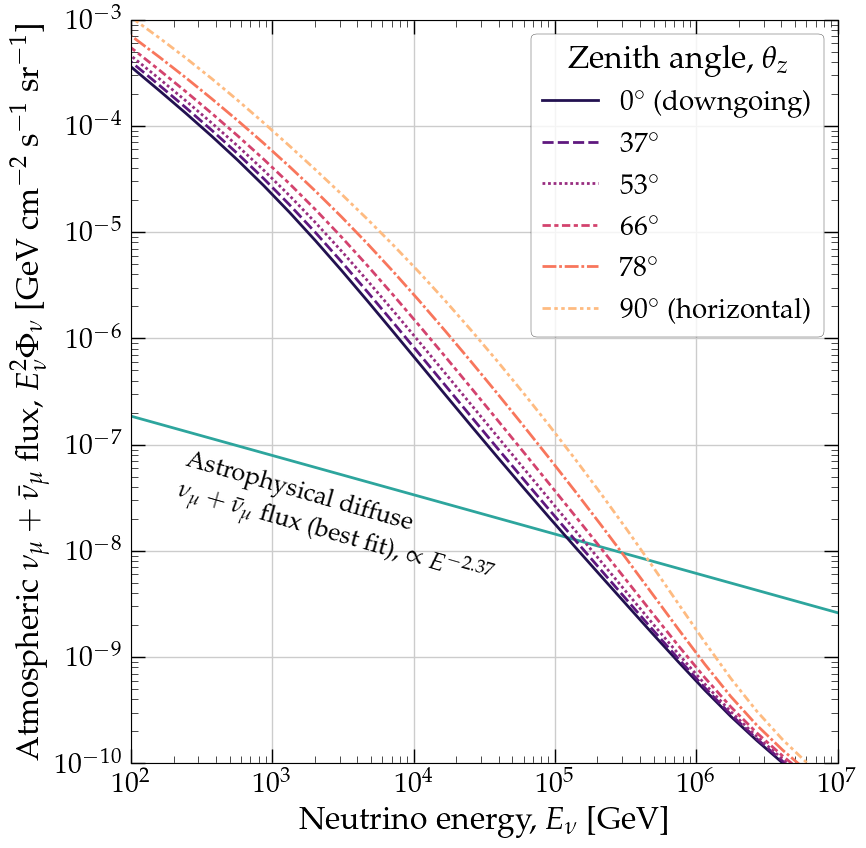

In [71]:
column_names = []
slicer = 4
for z in zen[:24:slicer]:
    if (z == 0.0): 
        label = rf"${z:1.0f}^\circ$ (downgoing)" 
    elif (z == 90.0): 
        label = rf"${z:1.0f}^\circ$ (horizontal)" 
    else:
        label = rf"${z:1.0f}^\circ$" 
    column_names.append(label)
    # column_names.append(rf"${z:1.0f}^\circ$")

energy_scaler = 2
scaled_bckg_flux = bckg_flux.T * (e_grid**energy_scaler)
df = pd.DataFrame(scaled_bckg_flux.T[:, :24:slicer], columns=column_names)
df["E"] = e_grid
df.set_index("E", inplace=True)


f, ax = plt.subplots(figsize=(9, 9))
ax = sns.lineplot(data=df, palette="magma")
plt.loglog()
ax.set_xlim(1e2, 1e7)
if energy_scaler == 3:
    ax.set_ylim(1e-4, 0.2)
else:
    ax.set_ylim(1e-10, 1e-3)
ax.set_xlabel(r"Neutrino energy, $E_{\nu}$ [GeV]", fontsize=23)
# ax.set_ylabel(
#     r"Atmospheric $\nu_\mu+\bar{\nu}_\mu$ flux, "
#     + "\n"
#     + rf"$E_\nu^{{{energy_scaler}}}"
#     + r" \Phi_\nu$ "
#     + r"[GeV~cm$^{-1}$~s$^{-1}$]"
# )
ax.set_ylabel(
    r"Atmospheric $\nu_\mu+\bar{\nu}_\mu$ flux, "+rf"$E_\nu^{{{energy_scaler}}}"+r"\Phi_\nu$ [GeV~cm$^{-2}$~s$^{-1}$~sr$^{-1}$]",
    fontsize=23
)
ax.plot(
    e_grid,
    st.PHI_ASTRO * ((e_grid / 1e5) ** -st.GAMMA_ASTRO) * e_grid**energy_scaler,
    color=st.colors[1], zorder=1
) # spectrum from  R. Abbasi et al 2022 ApJ 928 50
ax.text(
    s="Astrophysical diffuse"
    + "\n"
    + r" $\nu_\mu+\bar{\nu}_\mu$ flux  (best fit), "+rf"$\propto E^{{{-st.GAMMA_ASTRO}}}$",
    x=2e2,
    y=1.9e-8,
    rotation=-16,
    va="center",
    fontsize=18
)
ax.tick_params(axis='both', which='major', labelsize=20)

# ax.legend(
#     loc="upper center",
#     bbox_to_anchor=(0.5, 1.4),
#     ncol=2,
#     frameon=False,
#     title="Zenith angle"
# )
ax.legend(
    loc="upper right",
    # bbox_to_anchor=(0.5, 1.4),
    ncol=1,
    frameon=True,
    title=r"Zenith angle, $\theta_z$",
    title_fontsize=23,
    edgecolor='k',
    fontsize=20
)
f.savefig(
    join(st.BASEPATH, plot_path, "atmospheric_neutrino_spectrum.pdf"),
    bbox_inches="tight",
)

#  effective area & event rate
see Plenum/notebooks/demo/demo_plenum_effective_area.ipynb

## Preliminaries

In [4]:
with open(join(st.LOCALPATH, "inst_rel_events_ra_dec.pckl"), "rb") as f:
    rel_events_ra_dec, ra_vals, dec_vals = pickle.load(f)
aeff_2d, _, _, _ = get_aeff_and_binnings("upgoing")

In [11]:
rel_events_ra_dec[2].keys()

dict_keys(['Plenum-1', 'Plenum-2', 'IceCube', 'Gen-2', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'HUNT', 'TRIDENT', 'NEON'])

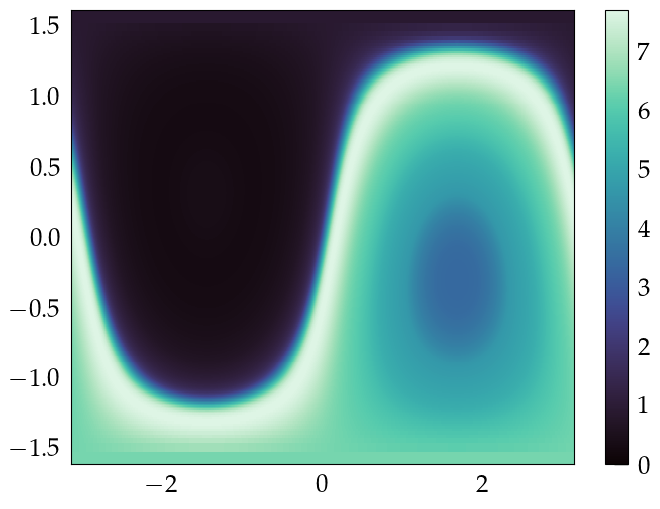

In [12]:
## CAUTION!! all event rates always normalized to 1 
# apply factor, if needed
plt.pcolormesh(
    np.pi - ra_vals,
    dec_vals,
    rel_events_ra_dec[2]["TRIDENT"] * st.TRIDENT_FACTOR,
    vmin=0,
    linewidth=0,
    rasterized=True,
)
plt.colorbar()

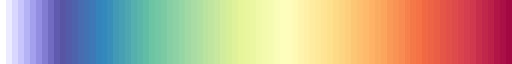

In [13]:
color_array_k = sns.cubehelix_palette(
    start=0, rot=0, light=1, dark=0.4, hue=1.2, n_colors=10
)
n2=38

color_array_b = sns.color_palette("Spectral_r", n_colors=n2*2)
_cmap = ListedColormap(np.concatenate([color_array_k, color_array_b]))
_cmap

## v2: Separate plots of effective area and event rate

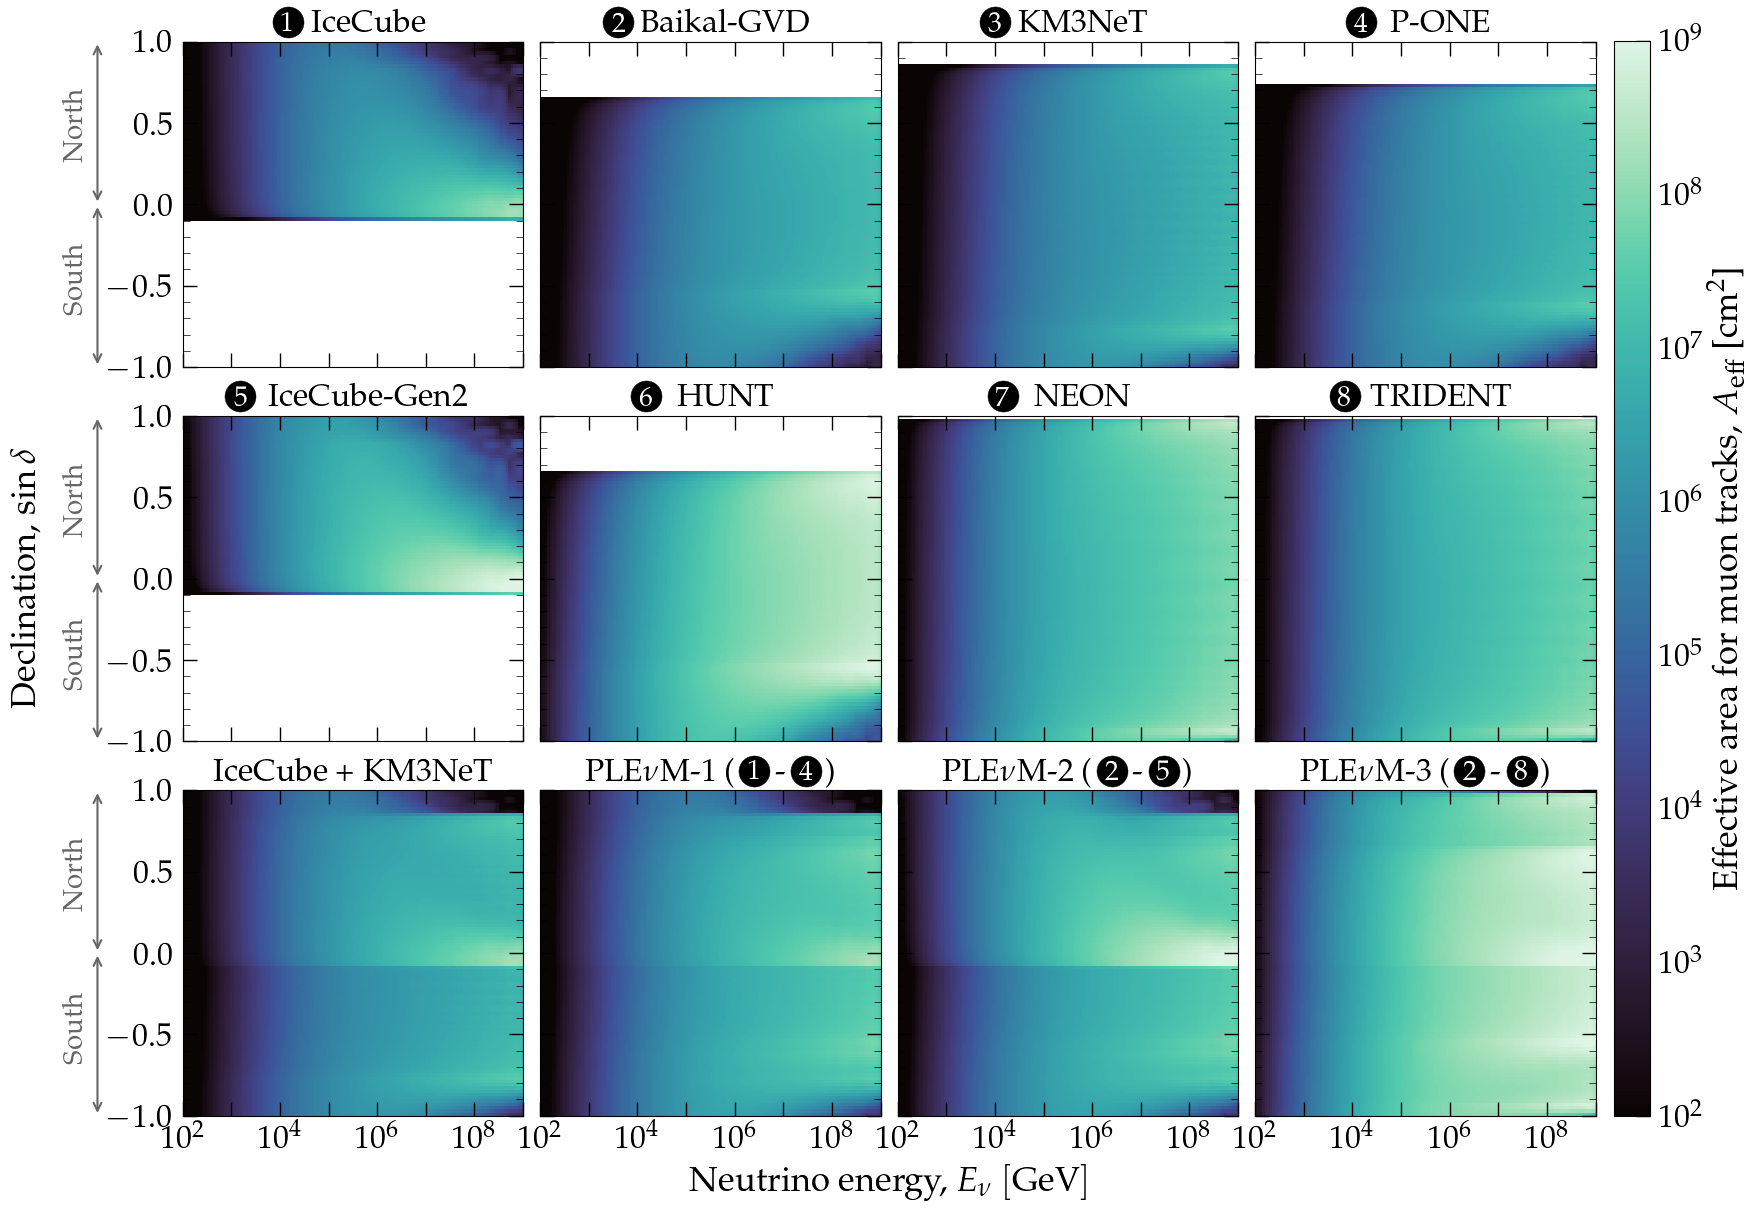

In [211]:
# vertical plot -  effective area only
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako_r", n_colors=14))
# ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako_r", n_colors=100))
ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako", n_colors=1000))

log_col = LogNorm(
    vmin=1e2,
    vmax=1e9,
)

heights = [1.0, 1.0, 1.0]
widths = [1.0, 1.0, 1.0, 1.0]
gs_kw = dict(height_ratios=heights, width_ratios=widths)
fig, axes = plt.subplots(
    nrows=3, ncols=4, figsize=(18, 13),
    # constrained_layout=True, 
    gridspec_kw=gs_kw
)
fig.subplots_adjust(hspace=0.15, wspace=0.05)

# IceCube
ax = axes[0][0]
ax.set_title("1~~IceCube", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["IceCube"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '1',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# Baikal-GVD
ax = axes[0][1]
ax.set_title("1~~Baikal-GVD", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["Baikal-GVD"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    0.4e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.232, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# KM3NeT
ax = axes[0][2]
ax.set_title("1~~KM3NeT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["KM3NeT"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '3',
    xy = (0.285, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# P-ONE
ax = axes[0][3]
ax.set_title("1~~P-ONE", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["P-ONE"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '4',
    xy = (0.312, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# IceCube-Gen2
ax = axes[1][0]
ax.set_title("1~~IceCube-Gen2", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["Gen-2"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e3, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '5',
    xy = (0.17, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# HUNT
ax = axes[1][1]
ax.set_title("1~~HUNT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["HUNT"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '6',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# NEON
ax = axes[1][2]
ax.set_title("1~~NEON", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["NEON"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    1.5e4, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '7',
    xy = (0.31, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# TRIDENT
ax = axes[1][3]
ax.set_title("1~~TRIDENT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["TRIDENT"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    7e3, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '8',
    xy = (0.26, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# IceCube + KM3NeT
ax = axes[2][0]
ax.set_title("IceCube + KM3NeT", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"]
        + aeff_2d["KM3NeT"]
    ).T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.annotate(
    '', 
    xy=(-0.25,1), xytext=(-0.25,0.5), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    '', 
    xy=(-0.25,0.5), xytext=(-0.25,0.0), 
    xycoords='axes fraction',
    annotation_clip=None, 
    arrowprops=dict(arrowstyle='<->', color='0.4', linewidth=1.5)
)
ax.annotate(
    'North', 
    xy=(-0.35,0.65),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)
ax.annotate(
    'South', 
    xy=(-0.35,0.18),
    fontsize=20,
    rotation=90,  
    c='0.4',
    xycoords='axes fraction',
    annotation_clip=None, 
)

# PLEnuM-1
ax = axes[2][1]
ax.set_title(r"PLE$\nu$M-1 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"]
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
    ).T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '1',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '4',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# PLEnuM-2
ax = axes[2][2]
ax.set_title(r"PLE$\nu$M-2 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"] * st.GEN2_FACTOR
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
    ).T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '5',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# PLEnuM-3
ax = axes[2][3]
ax.set_title(r"PLE$\nu$M-3 (~~1~\--~4~~)", fontsize=23)
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"] * st.GEN2_FACTOR
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
        + aeff_2d["NEON"]
        + aeff_2d["HUNT"]
        + aeff_2d["TRIDENT"]
    ).T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
    zorder=0.1
)
ax.scatter(
    2.5e6, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.scatter(
    3e7, 1.12, s=500, marker='o', c='k', clip_on=False, zorder=100
)
ax.annotate(
    '2',
    xy = (0.63, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)
ax.annotate(
    '8',
    xy = (0.78, 1.05), 
    xycoords='axes fraction', 
    ha='center', 
    va='center',
    c='w',
    fontsize=20,
    zorder=100,
    clip_on=False
)

# Formatting
for i in range(3):
    for j in range(4):
        axes[i][j].grid(False)
        axes[i][j].set_xscale('log')
        axes[i][j].set_xlim(1.e2, 1.e9)
        axes[i][j].set_ylim(-1.0, 1.0)
        axes[i][j].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
        axes[i][j].yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=0.1))
        axes[i][j].xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=15))
        axes[i][j].tick_params(axis='both', which='major', labelsize=23)
        if (i != 2):
            axes[i][j].xaxis.set_ticklabels([])
        else:
            # axes[i][j].xaxis.set_major_locator(matplotlib.ticker.FixedLocator(locs=[1.e2, 1.e4, 1.e6, 1.e8]))
            axes[i][j].xaxis.set_ticklabels(['', r'$10^2$', '', r'$10^4$', '', r'$10^6$', '', r'$10^8$', ''])
        if (j != 0):
            axes[i][j].yaxis.set_ticklabels([])

# Common x-axis, y-axis labels
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'Neutrino energy, $E_\nu~[{\rm GeV}]$', labelpad=10, fontsize=25)
plt.ylabel(r'Declination, $\sin \delta$', labelpad=70, fontsize=25)
plt.grid(False)

# Common colorbar
cbax = fig.add_axes([0.967, 0.137, 0.02, 0.827])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"Effective area for muon tracks, $A_{\rm eff}$~[cm$^2$]", fontsize=25)
cbax.tick_params(axis='both', which='major', labelsize=23)

# for ax in axes:
#     ax.set_ylabel(r"Declination $\sin(\delta)$")
#     ax.tick_params(direction="out", top=False, right=False)

# fig.tight_layout()
# # (left, bottom, width, height)
# cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# cb = fig.colorbar(p, cax=cbax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
# fig.subplots_adjust(right=0.88)
fig.savefig(
    join(st.BASEPATH, plot_path, "aeff_upgoing_all.pdf"), bbox_inches='tight', dpi=300
)

## v1: Joint plots of effective area and event rate

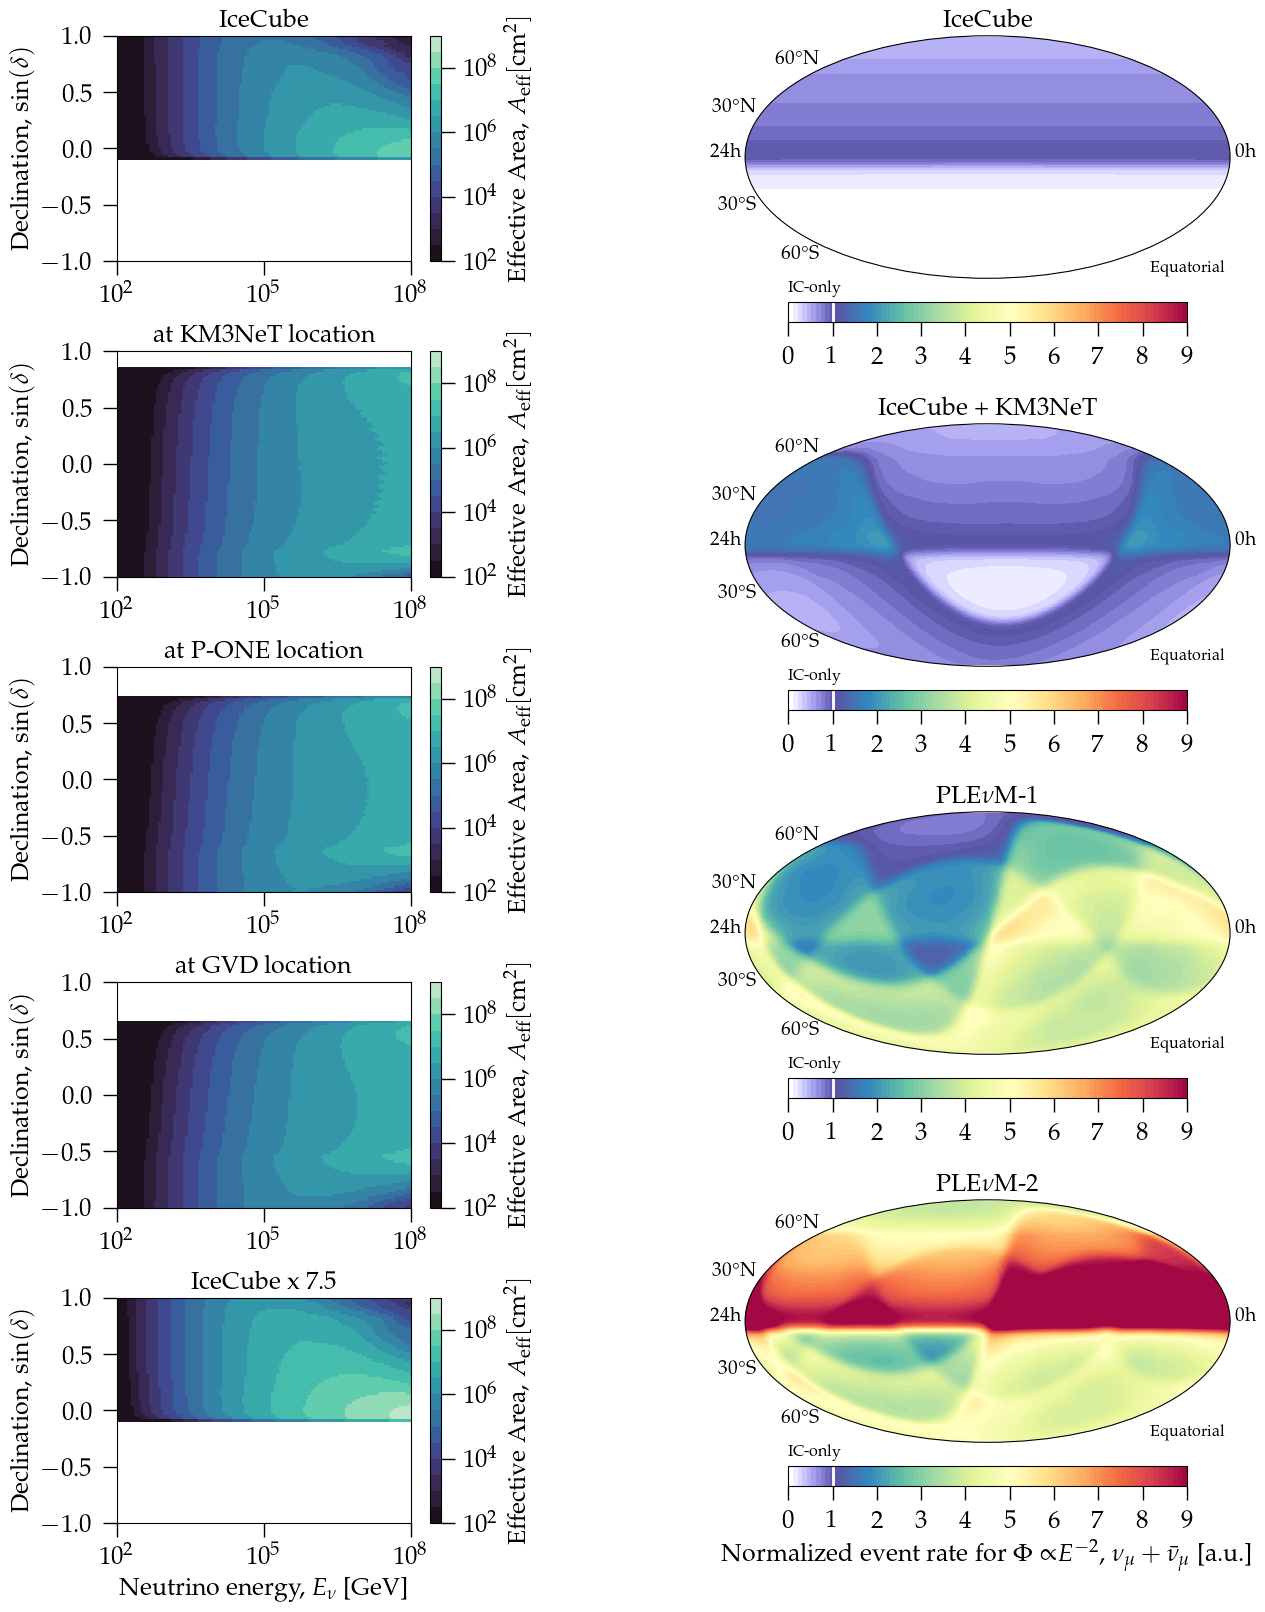

In [14]:
# vertical plot - let's get completely crazy here, because why not
ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako", n_colors=14))
ecap_listed_cmap.set_bad("w")
log_col = LogNorm(
    vmin=1e2,
    vmax=1e9,
)
# fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 18))
fig = plt.figure(figsize=(15, 18))
gs = GridSpec(1, 2, width_ratios=[1.2, 2], wspace=0.4, hspace=0.4)
gs0 = gs[0].subgridspec(5, 1, hspace=0.4)
gs1 = gs[1].subgridspec(4, 1)
for ii, det in enumerate(["IceCube", "KM3NeT", "P-ONE", "Baikal-GVD", "Gen-2"]):
    ax = fig.add_subplot(gs0[ii])
    ax.set_title(st.poles[det]["label"])
    p = ax.pcolormesh(
        st.ebins,
        st.sindec_bins,
        aeff_2d[det].T,
        norm=log_col,
        cmap=ecap_listed_cmap,
        linewidth=0,
        rasterized=True,
    )
    cb = plt.colorbar(p, ax=ax)
    cb.set_label(r"Effective Area, $A_{\rm eff} [\rm cm^2]$")
    cb.ax.tick_params(direction="out")
    ax.set_xscale("log")
    ax.set_xlim(1e2, 1e8)
    ax.set_ylabel(r"Declination, $\sin(\delta)$")
    ax.tick_params(direction="out", top=False, right=False)
    if False:  # det=="IceCube":
        ax.axhline(np.sin(np.deg2rad(-5)), color="gray", ls="--")
        ax.axhline(np.sin(np.deg2rad(30)), color="gray", ls="--")
ax.set_xlabel(r"Neutrino energy, $E_\nu$ [GeV]")

axes = []
plots = []
axes.append(fig.add_subplot(gs1[0], projection="mollweide"))
axes[-1].set_title(r"IceCube")
vmax = 9  # 1
plots.append(
    axes[-1].pcolormesh(
        np.pi - ra_vals,
        dec_vals,
        rel_events_ra_dec[2]["IceCube"],
        vmin=0,
        vmax=vmax,
        cmap=_cmap,
        linewidth=0,
        rasterized=True,
    )
)

axes.append(fig.add_subplot(gs1[1], projection="mollweide"))
axes[-1].set_title("IceCube + KM3NeT")
vmax = 9  # 2
plots.append(
    axes[-1].pcolormesh(
        np.pi - ra_vals,
        dec_vals,
        rel_events_ra_dec[2]["IceCube"] + rel_events_ra_dec[2]["KM3NeT"],
        vmin=0,
        vmax=vmax,
        cmap=_cmap,
        linewidth=0,
        rasterized=True,
    )
)

for i in [1, 2]:
    axes.append(fig.add_subplot(gs1[1 + i], projection="mollweide"))
    axes[-1].set_title(rf"PLE$\nu$M-{i}")
    vmax = 9  # np.ceil(np.max(rel_events_ra_dec[2][f"Plenum-{i}"]))
    plots.append(
        axes[-1].pcolormesh(
            np.pi - ra_vals,
            dec_vals,
            rel_events_ra_dec[2][f"Plenum-{i}"],
            vmin=0,
            vmax=vmax,
            cmap=_cmap,
            linewidth=0,
            rasterized=True,
        )
    )

for a, p in zip(axes, plots):
    cb = plt.colorbar(
        p, ax=a, shrink=0.65, orientation="horizontal", fraction=0.1, anchor=(0.5, 3)
    )
    cb.ax.tick_params(direction="out")
    cb.ax.set_xticks(np.arange(0, 10))
    cb.ax.axvline(1, color="w")
    cb.ax.text(0, 1.5, "IC-only", fontsize="small", transform=cb.ax.transAxes)
    cb.ax.text(
        1, 2.5, "Equatorial", ha="center", transform=cb.ax.transAxes, fontsize="small"
    )

    a.set_yticklabels([])
    a.text(-0.01, 0.5, "24h", transform=a.transAxes, ha="right")
    a.text(1.01, 0.5, "0h", transform=a.transAxes, ha="left")
    a.text(0.15, 0.9, "60°N", transform=a.transAxes, ha="right", va="center")
    a.text(0.02, 0.7, "30°N", transform=a.transAxes, ha="right", va="center")
    a.text(0.02, 0.3, "30°S", transform=a.transAxes, ha="right", va="center")
    a.text(0.15, 0.1, "60°S", transform=a.transAxes, ha="right", va="center")
cb.set_label(
    r"Normalized event rate for $\Phi \propto $"
    + r"$E^{-2}$"
    + r", $\nu_{\mu} + \bar{\nu}_{\mu}$ [a.u.]",
    # fontsize="large",
)

# fig.text(0.5, 0.17, s=r"IceCube " + "\n" + r" $\times 7.5$", fontsize="x-large")
fig.savefig(join(st.BASEPATH, plot_path, "aeff_upgoing_and_acceptance.png"))

## v0: Effective area

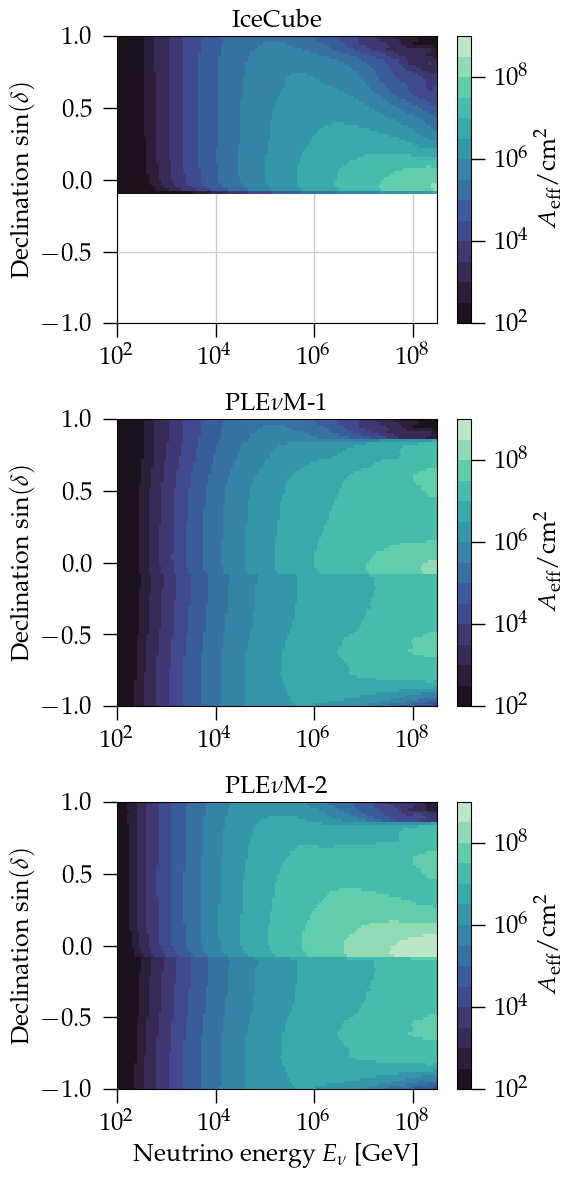

In [15]:
# vertical plot -  effective area only
ecap_listed_cmap = st.ListedColormap(sns.color_palette("mako", n_colors=14))
log_col = LogNorm(
    vmin=1e2,
    vmax=1e9,
)
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    aeff_2d["IceCube"].T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
cb.ax.tick_params(direction="out")
ax.set_xscale("log")
ax.set_xlim(1e2, 3e8)

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"]
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
    ).T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
cb.ax.tick_params(direction="out")
ax.set_xscale("log")
ax.set_xlim(1e2, 3e8)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    st.ebins,
    st.sindec_bins,
    (
        aeff_2d["IceCube"] * st.GEN2_FACTOR
        + aeff_2d["KM3NeT"]
        + aeff_2d["Baikal-GVD"]
        + aeff_2d["P-ONE"]
    ).T,
    norm=log_col,
    cmap=ecap_listed_cmap,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
cb.ax.tick_params(direction="out")
ax.set_xscale("log")
ax.set_xlim(1e2, 3e8)
ax.set_xlabel(r"Neutrino energy $E_\nu$ [GeV]")

for ax in axes:
    ax.set_ylabel(r"Declination $\sin(\delta)$")
    ax.tick_params(direction="out", top=False, right=False)

fig.tight_layout()
# # (left, bottom, width, height)
# cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# cb = fig.colorbar(p, cax=cbax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(
    join(st.BASEPATH, plot_path, "aeff_upgoing_comparison_IC_PLENUM-1-2_vertical.pdf")
)

# Energy resolution


In [72]:
# save for plotting script
with open(join(st.BASEPATH, "resources/baseline_energy_res_upgoing.pckl"), "rb") as f:
    baseline_eres_histo, baseline_eres_bins = load(f)

with open(join(st.BASEPATH, "resources/improved_energy_res_upgoing.pckl"), "rb") as f:
    improved_eres_histo, improved_eres_bins = load(f)

In [6]:
from matplotlib.colors import SymLogNorm

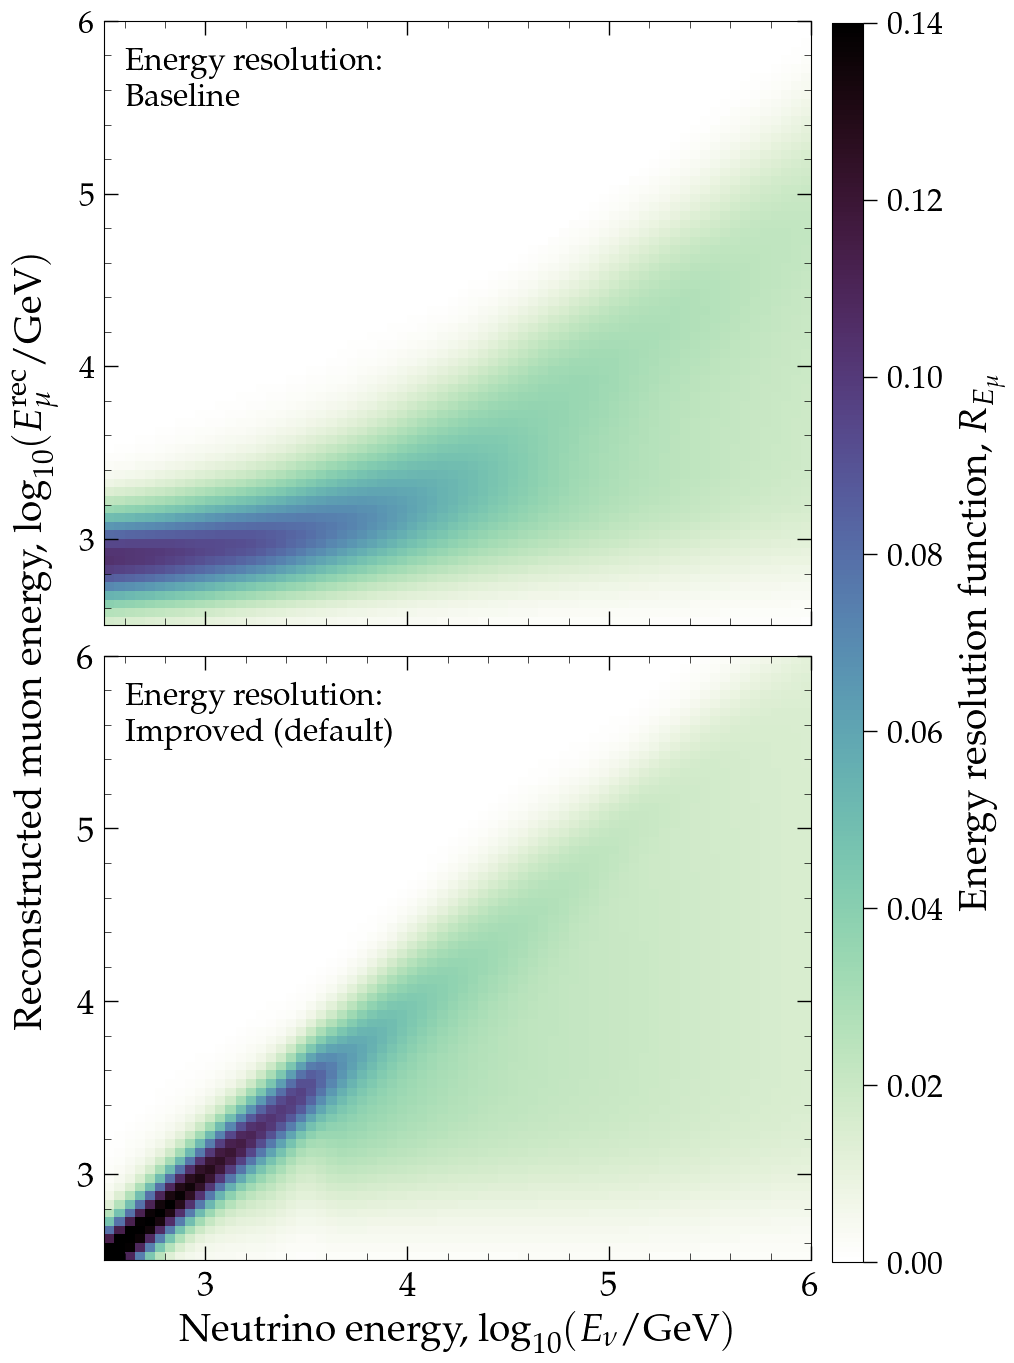

In [45]:
# nice plot
ebounds = (2.5, 6)
ticks = np.arange(3, 7)

_kw_mesh = dict(
    vmin=0.0,
    vmax=0.14,
    linewidth=0,
    rasterized=True,
    cmap=st.cmap_light,
    zorder=0.1
    #norm=SymLogNorm(linthresh=0.05, vmin=0, vmax=0.2),
)
f, axes = plt.subplots(nrows=2, figsize=(9, 15), sharex=True)
plt.subplots_adjust(hspace=0.05)

locator_major = ticker.MultipleLocator(1)
locator_minor = ticker.MultipleLocator(0.2)

# Baseline
ax = axes[0]
_kw_annotation = dict(
    xy=(ebounds[0] + 0.1, ebounds[1] - 0.15),
    color="k",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontweight="bold",
    fontsize=23,
)
im = ax.pcolormesh(*baseline_eres_bins, baseline_eres_histo.T, **_kw_mesh)
# ax.set_yticks(ticks)
# ax.tick_params(direction="in", top=True, right=True, left=True, bottom=True)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.annotate("Energy resolution:\n Baseline", **_kw_annotation)
ax.xaxis.set_major_locator(locator_major)
ax.yaxis.set_major_locator(locator_major)
ax.xaxis.set_minor_locator(locator_minor)
ax.yaxis.set_minor_locator(locator_minor)
ax.tick_params(axis='both', which='major', labelsize=23)
ax.grid(False)

# Improved
ax = axes[1]
_kw_annotation = dict(
    xy=(ebounds[0] + 0.1, ebounds[1] - 0.15),
    color="k",
    transform=ax.transAxes,
    ha="left",
    va="top",
    # fontweight="bold",
    fontsize=23,
)
im = ax.pcolormesh(*improved_eres_bins, improved_eres_histo.T, **_kw_mesh)
ax.annotate("Energy resolution:\n Improved (default)", **_kw_annotation)
# ax.set_yticks(ticks)
# ax.tick_params(direction="in", top=True, right=True, left=True, bottom=True, size=20)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_xlabel(r"Neutrino energy, $\log_{10}(E_{\nu}/{\rm GeV})$", fontsize=28)
ax.xaxis.set_major_locator(locator_major)
ax.yaxis.set_major_locator(locator_major)
ax.xaxis.set_minor_locator(locator_minor)
ax.yaxis.set_minor_locator(locator_minor)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.grid(False)

# Common y-axis label
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.ylabel(r"Reconstructed muon energy, $\log_{10}(E_{\mu}^{\rm rec}/{\rm GeV})$", fontsize=28)
plt.grid(alpha=0)

# Common c-axis label
cax = f.add_axes([0.98, 0.136, 0.035, 0.826])
cb = f.colorbar(im, cax=cax)
cb.ax.tick_params(direction="out", labelsize=23)
cb.set_label(r"Energy resolution function, $R_{E_\mu}$", labelpad=12, fontsize=28)
# cb.set_label(r"$P(E_{\mu}^{\rm reco}|E_{\nu})$")
# cb.set_ticks(np.arange(0, 0.16, step=0.03))

# f.tight_layout()
f.savefig(
    join(st.BASEPATH, plot_path, "energy_resolution_comparison.pdf"),
    bbox_inches="tight",
)

# Angular resolution

In [46]:
with open(join(st.BASEPATH, "resources/energy_psi.pckl"), "rb") as f:
    e_psi2_grid, e_psi2_bins = pickle.load(f)

['$10^{2}$ GeV', '$10^{3}$ GeV', '$10^{4}$ GeV', '$10^{5}$ GeV', '$10^{6}$ GeV', '$10^{7}$ GeV', '$10^{8}$ GeV']


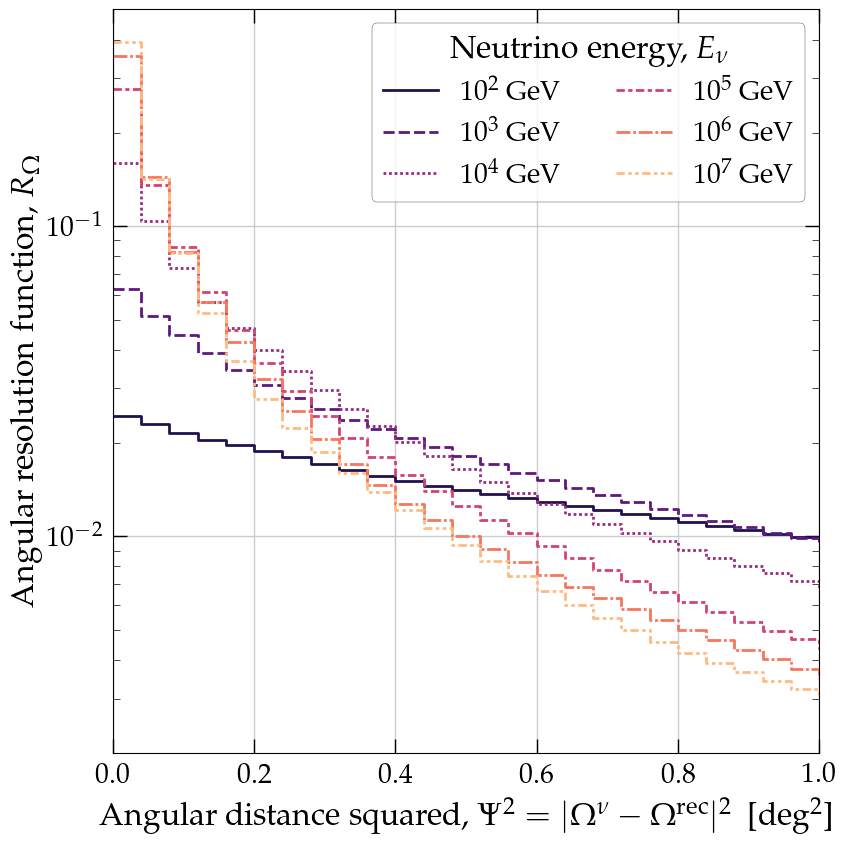

In [67]:
# OPTION 1)
if False:
    f, ax = plt.subplots(figsize=(9, 9))
    # ax.set_title("Angular resolution")
    ax.set_ylim(2.5, 5)
    ax.set_xlim(0, 1)
    ax.set_ylabel(r"Neutrino energy, $\log_{10}(E_{\nu}/{\rm GeV})$")
    ax.set_xlabel(
        r"Angular resolution - squared, "
        + "\n"
        + r"$\Psi^2 = |\Omega^\nu - \Omega^{\rm rec}|^2$"
    )
    # ax.set_xlabel(
    #     r"Angular resolution - squared, "
    #     + "\n"
    #     + r"$\Psi^2 = |\Omega^\nu - \Omega^{\rm rec}|^2$"
    # )
    ax.tick_params(direction="out", top=False, right=False)

    p = ax.pcolormesh(
        e_psi2_bins[0],
        e_psi2_bins[1],
        e_psi2_grid.T,
        # vmin=0,
        # vmax=0.15,
        norm=LogNorm(vmin=3e-3, vmax=2e-1),
        linewidth=0,
        rasterized=True,
    )
    cb = plt.colorbar(p)
    cb.set_label(
        r"Angular resolution, $R_{\Omega}(\Omega^\nu, \Omega^{\rm rec}, E_\nu)$"
    )
    cb.ax.tick_params(direction="out")

# OPTION 2
else:
    column_names = []
    slicer = 20
    for e in e_psi2_bins[1][:-1:slicer]:
        column_names.append(rf"$10^{{{e:1.0f}}}$ GeV")

    print(column_names)
    df = pd.DataFrame(e_psi2_grid[:, ::slicer], columns=column_names)
    df["psi2"] = e_psi2_bins[0][:-1]
    df.set_index("psi2", inplace=True)

    f, ax = plt.subplots(figsize=(9, 9))
    lp = sns.lineplot(data=df[df.columns[:-1]], ds="steps-post", palette="magma")
    plt.yscale("log")
    plt.xlim(0, 1)
    plt.ylim(2e-3, 5e-1)
    plt.xlabel(
        r"Angular distance squared, $\Psi^2 = |\Omega^\nu - \Omega^{\rm rec}|^2$~ [deg$^2$]",
        fontsize=23
    )
    # plt.xlabel(
    #     "Angular distance - squared, "
    #     + "\n"
    #     + r"$\Psi^2 = |\Omega^\nu - \Omega^{\rm rec}|^2$~ [deg$^2$]"
    # )
    plt.ylabel(
        r"Angular resolution function, $R_{\Omega}$" ,
        fontsize=23
    )
    ax.tick_params(axis='both', which='major', labelsize=20)
    lp.legend(
        loc="upper right", 
        # bbox_to_anchor=(0.5, 1.35), 
        ncol=2, 
        frameon=True,
        edgecolor='k',
        title=r'Neutrino energy, $E_\nu$',
        title_fontsize=23,
        fontsize=20
    )
    f.savefig(
        join(st.BASEPATH, plot_path, "energy_angular_resolution.pdf"),
        bbox_inches="tight",
    )

# DP source


In [11]:
flux_ps = pd.read_pickle(join(st.BASEPATH, "resources/flux_ngc_disc_pot.pickle"))

In [12]:
# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube (IC) 10 yr (est.)",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "IC_North_det": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC 14~yr + IC-North 10~yr",
        "plainlabel": "IC_North_det",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "KM3NeT-only": {
        "color": "#66cccc",
        "ls": "-.",
        "label": "KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC 14~yr + PLE$\nu$M-1 10~yr",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC 14~yr + PLE$\nu$M-2 10~yr",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },    
    "Plenum-3": {
        "color": "indigo",
        "ls": "-.",
        "label": r"IC 14~yr + PLE$\nu$M-3 10~yr",
        "plainlabel": r"PLE$\nu$M-3",
        "marker": "o",
    },
}

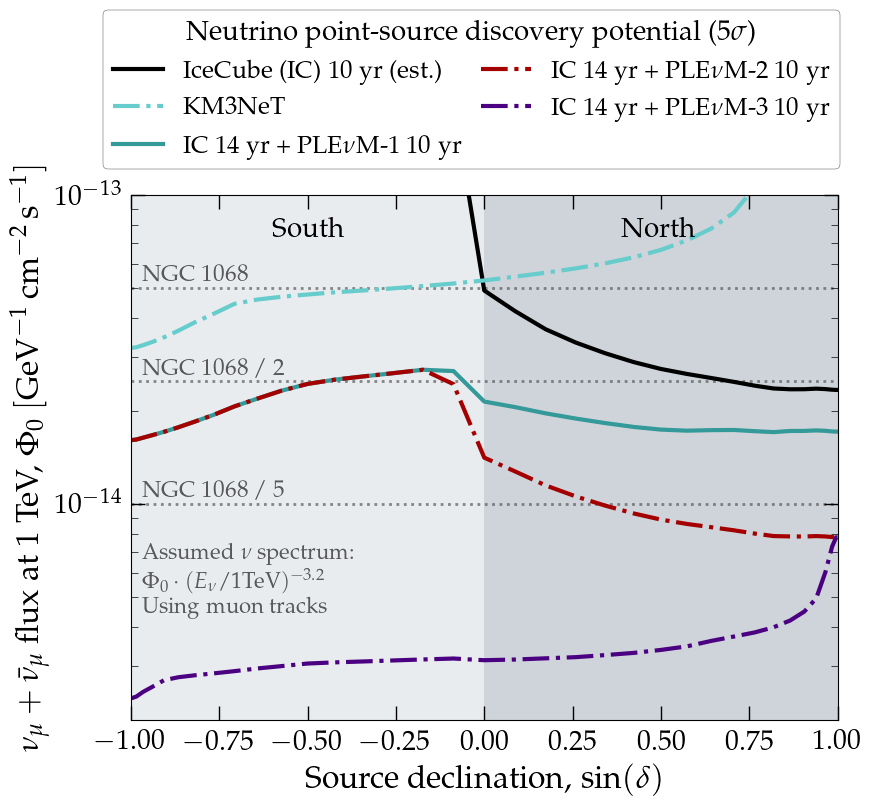

In [23]:
f, ax = plt.subplots(figsize=(9, 9))

ax.fill_between(
    x=[-1.0,0.0],
    y1=[1.e-13,1.e-13],
    y2=1.e-15,
    fc='#e9ecef',
    zorder=0.1
)
ax.fill_between(
    x=[0.0,1.0],
    y1=[1.e-13,1.e-13],
    y2=1.e-15,
    fc='#ced4da',
    zorder=0.1
)


for ident, series in flux_ps.groupby("ident"):
    if ident == "KM3NeT":
        continue
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )
ax.grid(False)
ax.set_yscale("log")
ax.set_xlabel(r"Source declination, $\sin(\delta)$", fontsize=23)
# ax.set_ylabel(
#     r"$\Phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
# )
ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)
f.legend(
    loc="upper center",
    frameon=True,
    # fontsize="large",
    ncol=2,
    bbox_to_anchor=(0.55, 0.94),
    columnspacing=0.8,
    edgecolor='k',
    title=r'Neutrino point-source discovery potential (5$\sigma$)',
    title_fontsize=20,
    fontsize=18
)
ax.set_ylim(2e-15, 1e-13)
ax.set_xlim(-1, 1)
font_color = "0.35"
for ii in [1, 2, 5]:
    ax.axhline(ngc_flux.norm / ii, ls=":", lw=2, color=font_color, zorder=0.2, alpha=0.7)
    ax.text(
        x=-0.97,
        y=ngc_flux.norm / ii,
        va="bottom",
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large",
        ha="left",
    )
ax.text(
    0.2, 0.92, "South", fontsize="x-large", color='k', transform=ax.transAxes
)
ax.text(
    0.8,
    0.92,
    "North",
    ha="right",
    fontsize="x-large",
    color='k',
    transform=ax.transAxes,
)
ax.tick_params(axis='both', which='major', labelsize=20)

f.subplots_adjust(top=0.72)
# ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
# ax.set_title(r"Neutrino point-source discovery ($5\sigma$)")
ax.annotate(
    r"Assumed $\nu$ spectrum: "
    + "\n"
    + r"$\Phi_0 \cdot (E_\nu/{\rm 1 TeV})^{-3.2}$"
    + "\n Using muon tracks",
    #     xy=(2037.5, 0.045),
    xy=(-0.97, 7.5e-15),
    ha="left",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)

f.savefig(join(st.BASEPATH, plot_path, "ngc_disc_pot.pdf"), bbox_inches="tight")

# discrimination PL EC


In [22]:
flux_ec = pd.read_pickle(
    join(st.BASEPATH, "resources/flux_ngc_spectral_disc_pot.pickle")
)

## v1

In [23]:
# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube (IC) 10 yr (est.)",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "IC_North_det": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC 14~yr + IC-North 10~yr",
        "plainlabel": "IC_North_det",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "KM3NeT-only": {
        "color": "#66cccc",
        "ls": "-.",
        "label": "KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC 14~yr + PLE$\nu$M-1 10~yr",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC 14~yr + PLE$\nu$M-2 10~yr",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },    
    "Plenum-3": {
        "color": "indigo",
        "ls": "-.",
        "label": r"IC 14~yr + PLE$\nu$M-3 10~yr",
        "plainlabel": r"PLE$\nu$M-3",
        "marker": "o",
    },
}

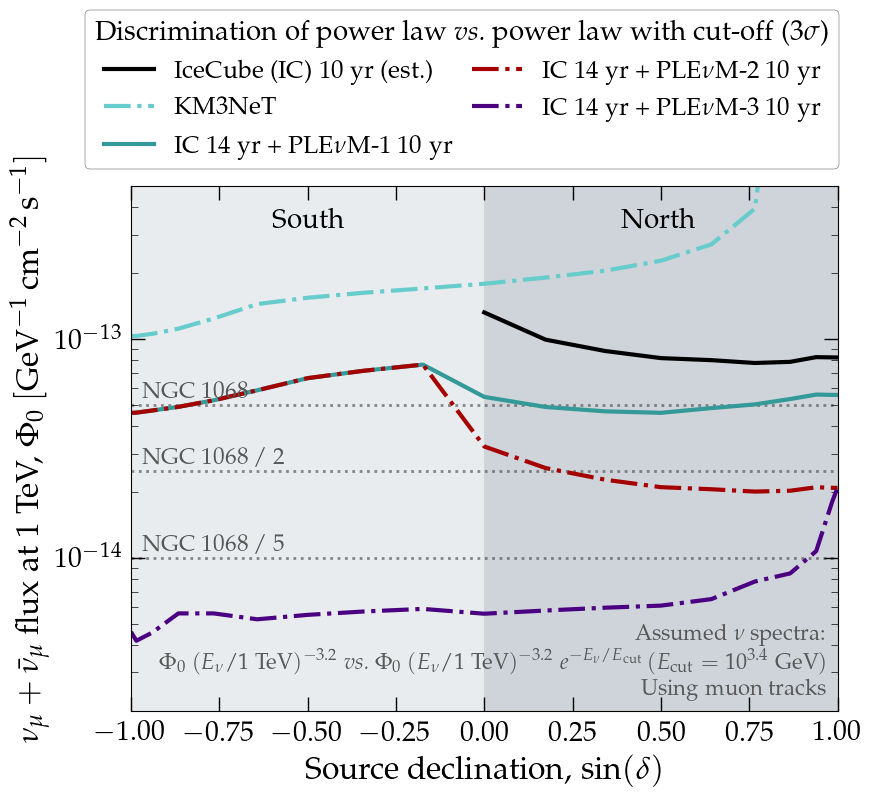

In [49]:
f, ax = plt.subplots(figsize=(9, 9))

ax.fill_between(
    x=[-1.0,0.0],
    y1=[5.e-13,5.e-13],
    y2=1.e-15,
    fc='#e9ecef',
    zorder=0.1
)
ax.fill_between(
    x=[0.0,1.0],
    y1=[5.e-13,5.e-13],
    y2=1.e-15,
    fc='#ced4da',
    zorder=0.1
)


for ident, series in flux_ec.groupby("ident"):
    if ident == "KM3NeT":
        continue
    plt.plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )
ax.grid(False)
ax.set_yscale("log")
ax.set_xlabel(r"Source declination, $\sin(\delta)$", fontsize=23)
# ax.set_ylabel(
#     r"$\Phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
# )
ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1~TeV, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)
f.legend(
    loc="upper center",
    frameon=True,
    # fontsize="large",
    ncol=2,
    bbox_to_anchor=(0.54, 0.93),
    columnspacing=0.8,
    edgecolor='k',
    title=r'Discrimination of power law~{\it vs.}~power law with cut-off (3$\sigma$)',
    title_fontsize=20,
    fontsize=18
)
ax.set_ylim(2e-15, 5e-13)
ax.set_xlim(-1, 1)
font_color = "0.35"
for ii in [1, 2, 5]:
    ax.axhline(ngc_flux.norm / ii, ls=":", lw=2, color=font_color, zorder=0.2, alpha=0.7)
    ax.text(
        x=-0.97,
        y=ngc_flux.norm / ii,
        va="bottom",
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large",
        ha="left",
    )
ax.text(
    0.2, 0.92, "South", fontsize="x-large", color='k', transform=ax.transAxes
)
ax.text(
    0.8,
    0.92,
    "North",
    ha="right",
    fontsize="x-large",
    color='k',
    transform=ax.transAxes,
)
ax.tick_params(axis='both', which='major', labelsize=20)

f.subplots_adjust(top=0.72)
# ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
# ax.set_title(r"Neutrino point-source discovery ($5\sigma$)")
ax.annotate(
    r"Assumed $\nu$ spectra: "
    + "\n"
    + r"$\Phi_0~(E_\nu/{\rm 1~TeV})^{-3.2}$"
    + r"~{\it vs.}~$\Phi_0~(E_\nu/{\rm 1~TeV})^{-3.2}~e^{-E_\nu/E_{\rm cut}}~(E_{\rm cut} = 10^{3.4}~{\rm GeV})$" 
    + "\n Using muon tracks",
    #     xy=(2037.5, 0.045),
    xy=(0.97, 5.e-15),
    ha="right",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)

f.savefig(join(st.BASEPATH, plot_path, "ngc_spectral_disc_pot.pdf"), bbox_inches="tight")

## v0

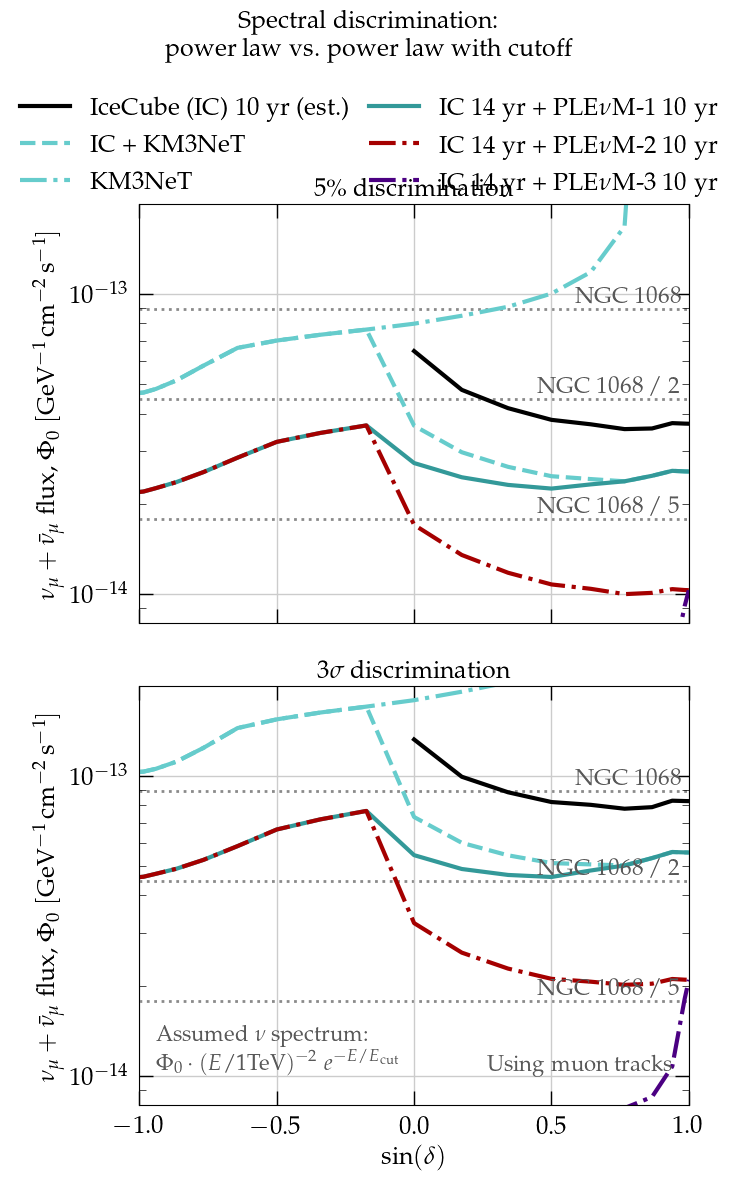

In [25]:
# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot 5% and 3sigma  thresholds
f, axes = plt.subplots(nrows=2, figsize=(7, 13), sharex=True)
for ident, series in flux_ec.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]},
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]},
    )
for ax in axes:
    ax.set_yscale("log")
    for ii in [1, 2, 5]:
        ax.axhline(
            ngc_cut_flux.norm / ii, ls=":", lw=2, color=font_color, zorder=0, alpha=0.7
        )
        ax.text(
            x=0.97,
            y=ngc_cut_flux.norm / ii,
            va="bottom",
            s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
            color=font_color,
            fontsize="large",
            ha="right",
        )
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\nu_\mu + \bar{\nu}_\mu$ flux, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
        fontsize=18,
    )
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.83)
f.suptitle(
    "Spectral discrimination: \n power law vs. power law with cutoff", fontsize=18
)
axes[1].annotate(
    r"Assumed $\nu$ spectrum: "
    + "\n"
    + r"$\Phi_0 \cdot (E/{\rm 1 TeV})^{-2}~e^{-E/E_{\rm cut}}$",
    xy=(-0.94, 1e-14),
        #xy=(-0.94, 1.8e-13),
    ha="left",
    va="bottom",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)
axes[1].annotate(
    "Using muon tracks",
    xy=(0.94, 1e-14),
        #xy=(0.94, 1.8e-13),
    ha="right",
    va="bottom",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)
f.savefig(
    join(st.BASEPATH, plot_path, "ngc_spectral_disc_pot.pdf"), bbox_inches="tight"
)

# Time evolution

## point source discovery

In [26]:
flux_psd = pd.read_csv(
    "../../resources/point-source_discovery_time-evolution.csv"
)


In [27]:

# icecube_ref_time = st.LIVETIME_DAYS / 365 # in years; approx. 9.7 Years of full detector (NGC 1068 analysis)

# start_dates = [
#     {"label": r"IceCube", "detector": "IceCube", "Year": 2020-icecube_ref_time, "colors": "0.8", "end": 2040},
#     {"label": r"+ 7.5$\times$ IceCube (South)", "detector": "Gen-2", "Year": 2040, "colors": "0.5", "end": 2060},
#     {"label": r"+ 1$\times$ IceCube (North)", "detector": "KM3NeT", "Year": 2025, "colors": st.colors[2], "end": 2060},
#     {"label": r"+ 1$\times$ IceCube (North)", "detector": "Baikal-GVD", "Year": 2030, "colors": st.colors[1], "end": 2060},
#     {"label": r"+ 1$\times$ IceCube (North)", "detector": "P-ONE", "Year": 2035, "colors": st.colors[0], "end": 2060},
# ]
# start_dates = pd.DataFrame(start_dates)
# start_dates = start_dates.set_index("detector")
# yr_max = 2055
# Years = np.arange(2020, yr_max)

# squished timeline

icecube_ref_time = st.LIVETIME_DAYS / 365  # approx. 9.7 Years of full detector (NGC 1068 analysis)

start_dates = [
    {"label": r"IceCube", "detector": "IceCube", "Year": 2020-icecube_ref_time, "colors": "0.8", "end": 2035},
    {"label": r"IceCube", "detector": "IceCube extrapolated", "Year": 2020-icecube_ref_time, "colors": "0.8", "end": 2060}, ## WIP
    {"label": r"+ 7.5$\times$ IceCube (South)", "detector": "Gen-2", "Year": 2035, "colors": "0.5", "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "KM3NeT", "Year": 2025, "colors": st.colors[2], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "Baikal-GVD", "Year": 2028, "colors": st.colors[1], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "P-ONE", "Year": 2031, "colors": st.colors[0], "end": 2060},
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2050
Years = np.arange(2020, yr_max)


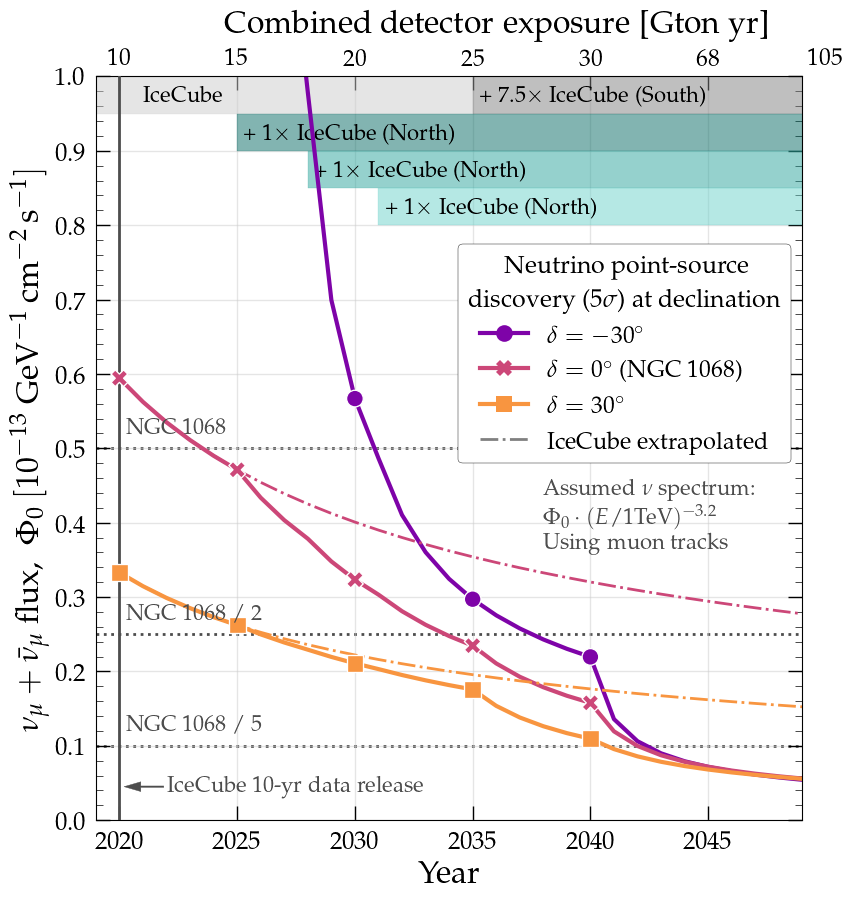

In [28]:
f, ax = plt.subplots(figsize=(9, 9))
# f, ax = plt.subplots(figsize=(6, 5))

edge = 1
ax.set_ylim(0, edge)
width = 0.5e-1  # 0.6e-1
font_color = "0.3"
sigma_ref = 5
ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "IceCube 10-yr data release",
    (2020.2, 0.045),
    (2022, 0.045),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize=16,  # "large",
)
ax.annotate(
    r"Assumed $\nu$ spectrum: "
    + "\n"
    + r"$\Phi_0 \cdot (E/{\rm 1 TeV})^{-3.2}$"
    + "\n Using muon tracks",
    xy=(2038, 0.46),
    ha="left",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)


for yr_i, series in start_dates.iterrows():
    if "extrapolated" in yr_i:
        continue
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.add_patch(
        Rectangle(
            (series.Year, edge), length, width, color=series.colors, zorder=1, alpha=0.5
        )
    )
    ax.text(
        x=series.Year + 0.3 if yr_i != "IceCube" else 2021,
        y=edge + 0.45 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize=16,  # "x-large",
        zorder=2,
    )
# plenum evolution
ax = sns.lineplot(
    data=flux_psd.loc[
        (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
    dashes=False,
)
# icecube-only extrapolated
ax = sns.lineplot(
    data=flux_psd.loc[
        (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "IceCube extrapolated")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=2,
    ls="-.",
    legend=False,
    palette="plasma",
)


# plenum evolution markers
selection = flux_psd.loc[
    (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)
# extra plotting for legend
selection = flux_psd.loc[
    (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=[
        r"$\delta = -30^\circ$",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$",
    ],
    style_order=[
        r"$\delta = -30^\circ$",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$",
    ],
    style="dec_label",
    units="dec",
    lw=3,
    ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
    dashes=False,
)
# IceCube extrapolated for legend
plt.plot([-1, -3], [-1, -3], ls="-.", color="gray", label="IceCube extrapolated")

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.79),
    #     bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    #     title="Source declination, $\delta$:",
    title=r"\hspace*{0.6em}Neutrino point-source\\[0.3em] discovery ($5\sigma$) at declination",
    ncol=1,
    fontsize=17,
    edgecolor="k",
)
plt.setp(legend.get_title(), fontsize=18)  # "x-large")
for line in legend.get_lines()[:-1]:
    line.set_linewidth(3)
    line.set_markersize(12)

# Top x-axis (artificial, for simplicity)
volume_ic = 1.0  # IceCube volume [Gton]
ic_start = 2010  # 2011


### UPDATE -- I think this was not right in the first place 
# ... it does not count the Northern detectors? Or do I see this wrong?
def exposure_combined(year):
    if year <= 2025:
        exposure = volume_ic * (year - ic_start)
    elif 2025 < year <= 2030:
        exposure = exposure_combined(2025) + (year - 2025) * volume_ic
    elif 2030 < year <= 2035:
        exposure = exposure_combined(2030) + (year - 2030) * volume_ic
    elif 2035 < year <= 2040:
        exposure = exposure_combined(2035) + (year - 2035) * volume_ic
    elif year > 2040:
        exposure = exposure_combined(2040) + (year - 2040) * 7.5 * volume_ic
    return exposure


for year in np.linspace(2020, 2050, 7):
    ax.text(
        x=year,
        y=1.015,
        s="{:0.0f}".format(exposure_combined(year)),
        fontsize=17,
        ha="center",
    )
ax.text(
    x=2036, y=1.06, s="Combined detector exposure [Gton~yr]", fontsize=23, ha="center"
)

ax.set_xlim(2019, yr_max - 1)
ax.set_xlabel(r"Year", fontsize=23)
ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux,~~$\Phi_{0} ~ [10^{-13}~\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)

for ii in [1, 2, 5]:
    ax.axhline(st.PHI_NGC * 1e13 / ii, ls=":", lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.3,
        y=0.02 + st.PHI_NGC * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize=16,  # "large",
        zorder=20,
    )

ax.grid(alpha=0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

# ax.set_title("Point-source discovery potential ($5 \sigma$)", fontsize="xx-large", pad=60)
f.savefig(
    join(st.BASEPATH, plot_path, "time_evolution_significance_ps.pdf"),
    dpi=300,
    bbox_inches="tight",
)

## spectral discrimination

In [29]:
flux_sd = pd.read_csv(join(st.BASEPATH, "resources/source_spectrum_time-evolution.csv"))

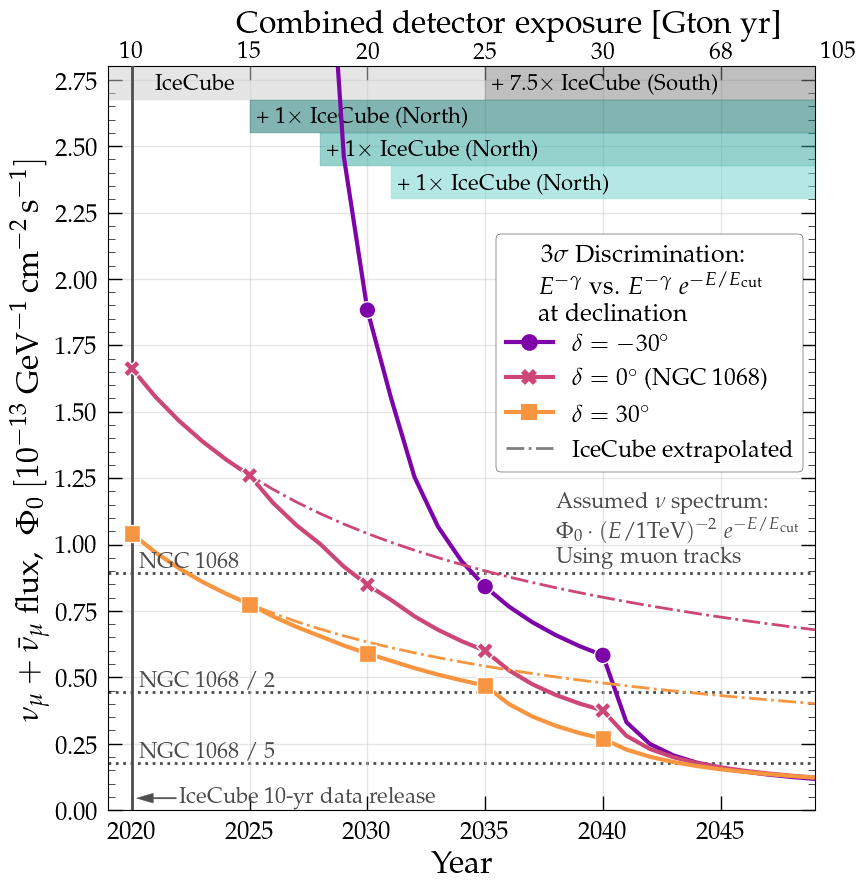

In [30]:
f, ax = plt.subplots(figsize=(9, 9))
# f, ax = plt.subplots(figsize=(6, 5))

edge = 2.8
ytop = edge + 0.03
ax.set_ylim(0, edge)
width = 1.25e-1  # 0.6e-1
font_color = "0.3"
sigma_ref = 3
ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "IceCube 10-yr data release",
    (2020.2, 0.045),
    (2022, 0.045),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize=16,  # "large",
)
ax.annotate(
    r"Assumed $\nu$ spectrum: "
    + "\n"
    + r"$\Phi_0 \cdot (E/{\rm 1 TeV})^{-2} ~e^{-E/E_{\rm cut}}$"
    + "\n Using muon tracks",
    #     xy=(2037.5, 0.045),
    xy=(2038, 1.2),
    ha="left",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)


for yr_i, series in start_dates.iterrows():
    if "extrapolate" in yr_i: continue
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.add_patch(
        Rectangle(
            (series.Year, edge), length, width, color=series.colors, zorder=1, alpha=0.5
        )
    )
    ax.text(
        x=series.Year + 0.3 if yr_i != "IceCube" else 2021,
        y=edge + 0.45 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize=16,  # "x-large",
        zorder=2,
    )
# plenum evolution
ax = sns.lineplot(
    data=flux_sd.loc[(flux_sd.sigma == sigma_ref) & (flux_sd.identifier == "PLEnuM")],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
    dashes=False,
)
# icecube-only extrapolated
ax = sns.lineplot(
    data=flux_sd.loc[
        (flux_sd.sigma == sigma_ref) & (flux_sd.identifier == "IceCube extrapolated")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=2,
    ls="-.",
    legend=False,
    palette="plasma",
)


# plenum evolution markers
selection = flux_sd.loc[(flux_sd.sigma == sigma_ref) & (flux_sd.identifier == "PLEnuM")]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)
# extra plotting for legend
selection = flux_sd.loc[(flux_sd.sigma == sigma_ref) & (flux_sd.identifier == "PLEnuM")]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=[
        r"$\delta = -30^\circ$",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$",
    ],
    style_order=[
        r"$\delta = -30^\circ$",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$",
    ],
    style="dec_label",
    units="dec",
    lw=3,
    ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
    dashes=False,
)
# IceCube extrapolated for legend
plt.plot([-1, -3], [-1, -3], ls="-.", color="gray", label="IceCube extrapolated")

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.79),
    #     bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    #     title="Source declination, $\delta$:",
    title=r"\hspace*{-0.7em}$3\sigma$ Discrimination: \\[0.3em]"
    + r"$E^{-\gamma}$ vs. $E^{-\gamma}~e^{-E/E_{\rm cut}}$ \\[0.3em]"
    + r"at declination",
    # title=r"\hspace*{-0.7em}$3\sigma$ Discrimination: \\[0.3em] Power law vs. \\[0.3em]Power law with cutoff\\[0.3em] at declination",
    ncol=1,
    fontsize=17,
    edgecolor="k",
)
plt.setp(legend.get_title(), fontsize=18)  # "x-large")
for line in legend.get_lines()[:-1]:
    line.set_linewidth(3)
    line.set_markersize(12)

# Top x-axis (artificial, for simplicity)
volume_ic = 1.0  # IceCube volume [Gton]
ic_start = 2010  # 2011

#### NEEDS TO BE UPDATED - SEE COMMENT ABOVE
def exposure_combined(year):
    if year <= 2025:
        exposure = volume_ic * (year - ic_start)
    elif 2025 < year <= 2030:
        exposure = exposure_combined(2025) + (year - 2025) * volume_ic
    elif 2030 < year <= 2035:
        exposure = exposure_combined(2030) + (year - 2030) * volume_ic
    elif 2035 < year <= 2040:
        exposure = exposure_combined(2035) + (year - 2035) * volume_ic
    elif year > 2040:
        exposure = exposure_combined(2040) + (year - 2040) * 7.5 * volume_ic
    return exposure


for year in np.linspace(2020, 2050, 7):
    ax.text(
        x=year,
        y=ytop,
        s="{:0.0f}".format(exposure_combined(year)),
        fontsize=17,
        ha="center",
    )
ax.text(
    x=2036,
    y=ytop + 0.1,
    s="Combined detector exposure [Gton~yr]",
    fontsize=23,
    ha="center",
)

ax.set_xlim(2019, yr_max - 1)
ax.set_xlabel(r"Year", fontsize=23)
ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux,~~$\Phi_{0} ~ [10^{-13}~\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)

for ii in [1, 2, 5]:
    ax.axhline(ngc_cut_flux.norm * 1e13 / ii, ls=":", lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.3,
        y=0.02 + ngc_cut_flux.norm * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize=16,  # "large",
        zorder=20,
    )

ax.grid(alpha=0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

# ax.set_title("Point-source discovery potential ($5 \sigma$)", fontsize="xx-large", pad=60)
f.savefig(
    join(st.BASEPATH, plot_path, "time_evolution_significance_spectral.pdf"),
    dpi=300,
    bbox_inches="tight",
)

# 2D ngc contour

In [19]:
contour_formats = {
    "IceCube": {"colors": [st.poles["IceCube"]["color"]], "linestyles": "--"},
    "IceCube - data release": {"colors": ["gray"], "linestyles": "--"},
    IC_North_det: {"colors": [st.poles[IC_North_det]["color"]], "linestyles": ":", "linewidths": 4},
    "Plenum-1": {
        "colors": [st.poles["Plenum-1"]["color"]],
        "linestyles": st.poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [st.poles["Plenum-2"]["color"]],
        "linestyles": st.poles["Plenum-2"]["ls"],
    },
    "Plenum-3": {
        "colors": [st.poles["Plenum-3"]["color"]],
        "linestyles": st.poles["Plenum-3"]["ls"],
    },
}
detector_keys = ["IceCube", IC_North_det, "Plenum-1", "Plenum-2", "Plenum-3"]
energy_reso = ["baseline", "improved"]

In [7]:
SPL_df = pd.read_csv("../../resources/ngc_contour_spl.csv")
SPL_df


,Unnamed: 0,LLH,energy_res,ident,ts,conv,phi_astro,gamma,delta_ts
0,0,global,baseline,IceCube,-2.938453e+05,1.000000,1.0,3.200,NaN
1,1,local,baseline,IceCube,-2.938410e+05,1.023324,0.5,2.800,4.394216
2,2,local,baseline,IceCube,-2.938413e+05,1.024059,0.5,2.825,4.086414
3,3,local,baseline,IceCube,-2.938415e+05,1.024748,0.5,2.850,3.893877
4,4,local,baseline,IceCube,-2.938415e+05,1.025388,0.5,2.875,3.798789
...,...,...,...,...,...,...,...,...,...
14213,14213,local,improved,Plenum-3,-1.294144e+06,0.987146,1.1,3.275,53.207145
14214,14214,local,improved,Plenum-3,-1.294139e+06,0.986967,1.1,3.280,57.591236
14215,14215,local,improved,Plenum-3,-1.294135e+06,0.986786,1.1,3.285,62.328922
14216,14216,local,improved,Plenum-3,-1.294129e+06,0.986602,1.1,3.290,67.418598


## simulation

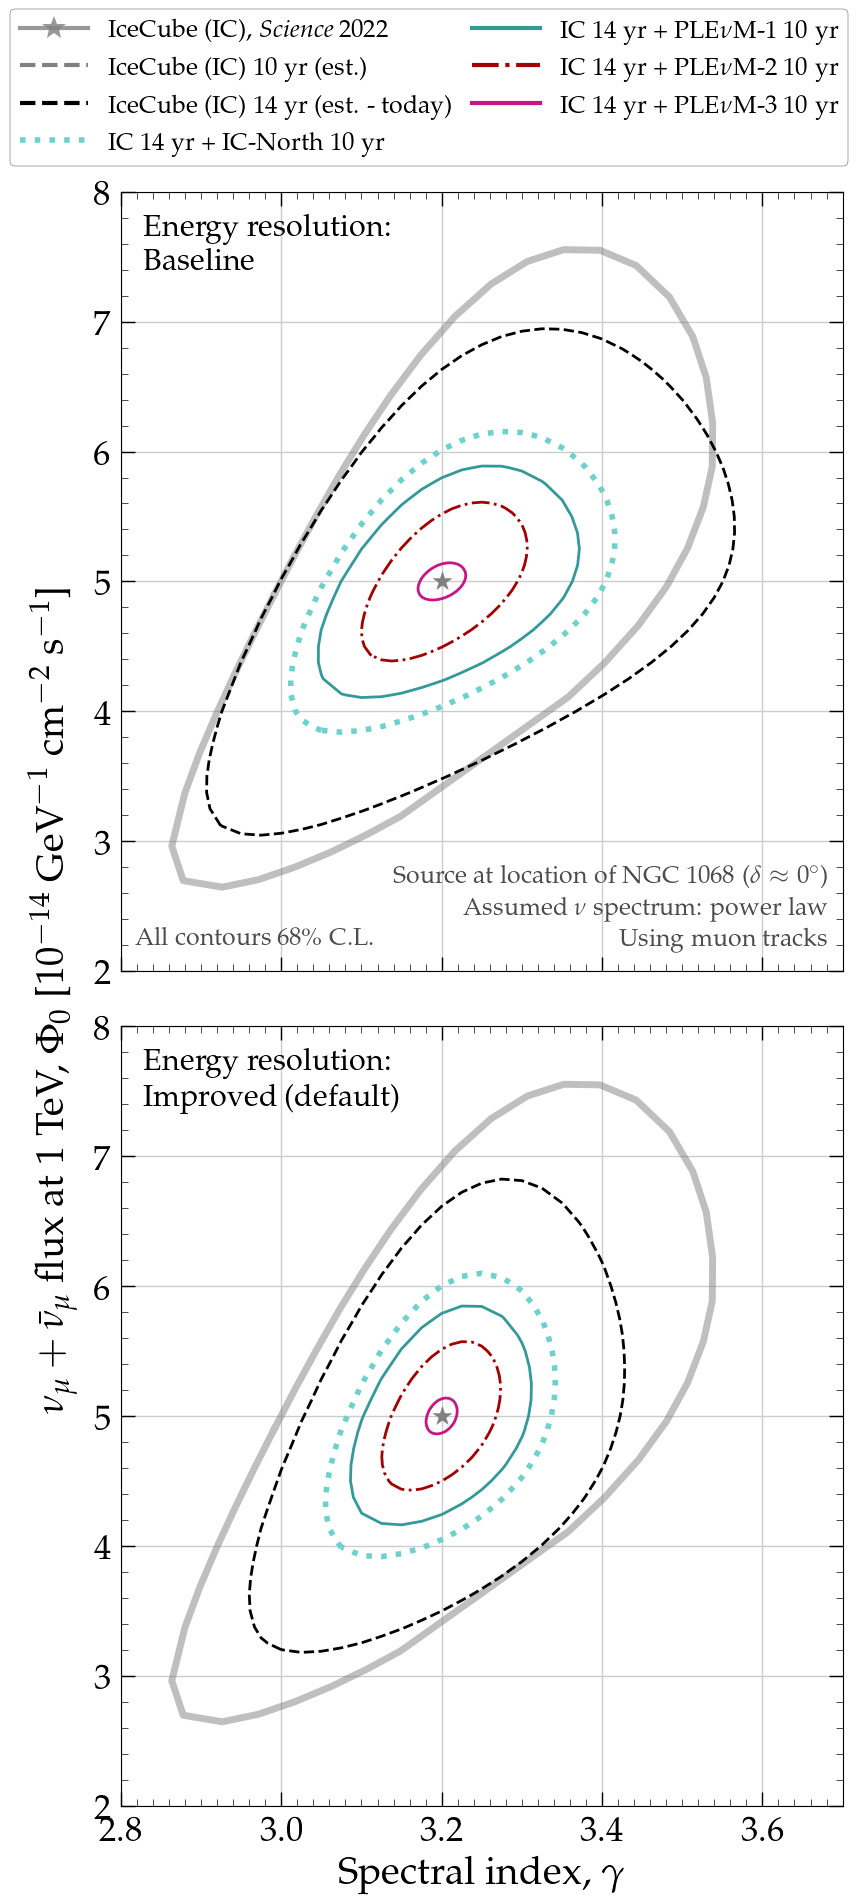

In [21]:
ref_color = "gray"

f, axes = plt.subplots(nrows=2, figsize=(9, 18), sharex=True)

for ii, eres_key in enumerate(energy_reso):
    ax = axes[ii]
    ax.plot(
        gamma_c_68,
        phi_c_68 * 1e11,
        color=ref_color,
        ls="-",
        lw=5,
        alpha=0.5,
    )

    # draw contour levels
    cvals = [0.32]
    lbs = ["68%"]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = ax.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
            **contour_formats[ident],
        )
#         fmt = {l: s for l, s in zip(sc.levels, lbs)}
#         ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    # best fit
    ax.scatter(
        res_global.gamma.unique(),
        res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
        marker="*",
        s=200,
        color="0.5",
        edgecolor=ref_color,
    )

    ax.set_ylim(2, 8)
    ax.set_xlim(2.8, 3.7)
#     ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
#     ax.set_title(f"{eres_key} energy resolution")

ax.set_xlabel(r"Spectral index, $\gamma$", fontsize=28)
axes[0].annotate(r'Energy resolution:'+'\n'r'Baseline', 
                 xy = (0.03, 0.90), 
                 xycoords='axes fraction', 
                 ha='left', 
                 fontsize=22)
axes[1].annotate(r'Energy resolution:'+'\n'r'Improved (default)', 
                 xy = (0.03, 0.90), 
                 xycoords='axes fraction', 
                 ha='left', 
                 fontsize=22)

font_color='0.3'
axes[0].annotate(r"Source at location of NGC 1068 ($\delta \approx 0^\circ$)",
                 xy=(0.98, 0.12),
                 xycoords='axes fraction', 
                 ha="right",
                 va="center",
                 zorder=10,
                 color=font_color,
                 fontsize=18)
axes[0].annotate(r"Assumed $\nu$ spectrum: power law",
                 xy=(0.98, 0.08),
                 xycoords='axes fraction', 
                 ha="right",
                 va="center",
                 zorder=10,
                 color=font_color,
                 fontsize=18)
axes[0].annotate(r"Using muon tracks",
                 xy=(0.98, 0.04),
                 xycoords='axes fraction', 
                 ha="right",
                 va="center",
                 zorder=10,
                 color=font_color,
                 fontsize=18)
axes[0].annotate(r"All contours 68\%~C.L.",
                 xy=(0.02, 0.04),
                 xycoords='axes fraction', 
                 ha="left",
                 va="center",
                 zorder=10,
                 color=font_color,
                 fontsize=18)

lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="0.5",
        mec=ref_color,
        label=r"IceCube (IC), {\it Science} 2022",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube - data release"]["colors"][0],
        ls=contour_formats["IceCube - data release"]["linestyles"],
        lw=3,
        label="IceCube (IC) 10 yr (est.)",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IceCube (IC) 14 yr (est. - today)",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats[IC_North_det]["colors"][0],
        ls=contour_formats[IC_North_det]["linestyles"],
        lw=4,
        label="IC 14~yr + IC-North 10~yr",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IC 14~yr + PLE$\nu$M-1 10~yr",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IC 14~yr + PLE$\nu$M-2 10~yr",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-3"]["colors"][0],
        ls=contour_formats["Plenum-3"]["linestyles"],
        lw=3,
        label=r"IC 14~yr + PLE$\nu$M-3 10~yr",
    ),
]
f.legend(
    handles=lines,
    loc="upper center",
    ncol=2,
    # fontsize="large",
    frameon=True,
    edgecolor='k',
    handlelength=2.7,
    bbox_to_anchor=(0.5,1.085),
    columnspacing=0.8,
)

for ax in axes:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    ax.tick_params(axis='both', labelsize=25)


# Common y-axis label
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel(r"$\nu_\mu + \bar{\nu}_\mu$ flux at 1 TeV, $\Phi_0$~[$10^{-14}~{\rm GeV}^{-1}~{\rm cm}^{-2}~{\rm s}^{-1}$]",
           fontsize=28, labelpad=2)
plt.grid(alpha=0)


# flux_str = r"$\frac{{\rm d}\Phi_{\rm astro}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
# flux_str += r"= \Phi_0 \left( \frac{E}{\rm 1\,TeV} \right)^{-\gamma}$"
# ax.text(
#     2.65,
#     7.0,
#     flux_str,
#     fontsize=20,
#     bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
# )
# f.suptitle(f"NGC1068 contour", fontsize="xx-large")
f.tight_layout()
# ax.grid(alpha=0.5)
# f.subplots_adjust(top=0.82)

f.savefig(join(st.BASEPATH, plot_path, "2D_scan_st.ngc1068.pdf"), dpi=300, bbox_inches='tight')

## Experimental data & comparison

In [37]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(
    join(st.BASEPATH, "resources/ngc_paper_68_contour.txt")
)
phi_c_68 /= 1e11

# 10yr PS paper (data release)
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(st.BASEPATH, "resources/tenyr_paper_68_contour.txt")
)
phi_c_68_prev *= 1e-3

In [38]:
collect_times = {
    "IceCube NGC 1068 (2020)": {
        "data": [2008.2633309090984, 2018.517733159589],
        "plotting_kw": {"marker": "o", "ls": ":", "color": "k", "ms": 10},
    },
    "PLEnuM data": {
        "data": [2012.318105689836, 2018.517733159589],
        "plotting_kw": {"marker": "*", "ls": "-", "color": "tomato", "ms": 15},
    },
    "IceCube NGC 1068 (2022)": {
        "data": [2011.3616438356164, 2020.4071038251366],
        "plotting_kw": {"marker": "s", "ls": "--", "color": "k", "ms": 10},
    },
}

In [39]:
# best-fit on exp data
with open(join(st.BASEPATH, "resources/exp_result.pckl"), "rb") as f:
    out_global_pl = load(f)
out_global_pl

(array([0.93189545, 1.0826587 , 3.2733312 ]), 4837.453799730767)

In [40]:
with open(join(st.BASEPATH, "resources/param_errors.pckl"), "rb") as f:
    n_avg_err, gamma_avg_err = load(f)

In [41]:
sig_ts = pd.read_csv(join(st.BASEPATH, "resources/ngc_2D_LLH_scan_exp_dataBG.csv"))


In [42]:
cur_cmap = sns.cubehelix_palette(
    start=-0.6, rot=0, light=1, dark=0.2, as_cmap=True, reverse=True
) 

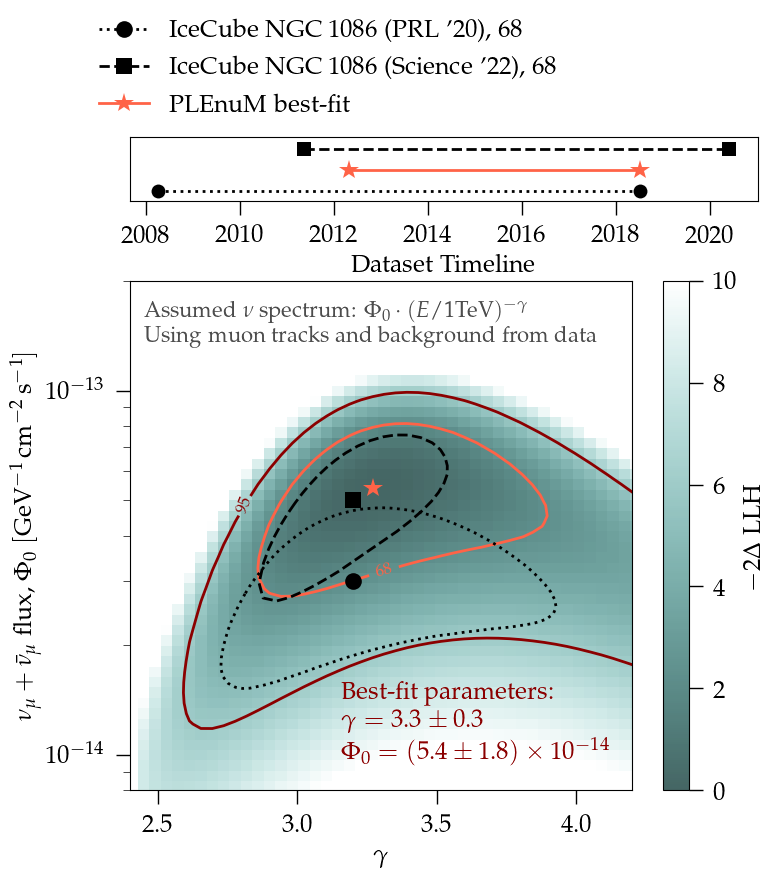

In [43]:
bg_from_data = True
savestr = "MCEq" if bg_from_data == False else "dataBG"
sig_ts = pd.read_csv(join(st.BASEPATH, f"resources/ngc_2D_LLH_scan_exp_{savestr}.csv"))
sig_ts["norm"] = sig_ts["ns"] * ngc_flux.norm
sig_ts_piv = sig_ts.pivot(index="norm", columns="gamma", values="delta_ts")
cvals = [0.32, 0.05]
lbs = ["68%", "95%"]
levels = chi2.isf(cvals, 2)

f, axes = plt.subplots(
    figsize=(8, 10), nrows=2, gridspec_kw={"height_ratios": [1, 8], "hspace": 0.28}
)

ax = axes[0]
# timeline
for ii, key in enumerate(collect_times):
    if key == "all":
        continue
    ax.plot(
        collect_times[key]["data"],
        np.repeat(ii, len(collect_times[key]["data"])),
        **collect_times[key]["plotting_kw"],
    )
ax.tick_params(direction="out", which="both", top=False, right=False)
ax.set_yticks([])
ax.grid(False)
ax.set_ylim(-0.5, 2.6)
ax.set_xlabel("Dataset Timeline")

ax = axes[1]

im = ax.pcolormesh(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    vmin=0,
    vmax=10,
    cmap=cur_cmap,
    alpha=0.8,
    linewidth=0,
    rasterized=True,
)
cb = plt.colorbar(im)
cb.set_label(r"$-2 \Delta$ LLH")
cb.ax.tick_params(direction="out")

ax.plot(gamma_c_68_prev, phi_c_68_prev, color="k", ls=":")
ax.plot(
    3.2,
    3e-14,
    color="k",
    marker="o",
    label="IceCube NGC 1086 (PRL '20), 68% C.L.",
    ms=12,
    ls=":",
)

ax.plot(gamma_c_68, phi_c_68 * 1e-3, color="k", ls="--")
ax.plot(
    3.2,
    5e-14,
    color="k",
    marker="s",
    label="IceCube NGC 1086 (Science '22), 68% C.L.",
    ms=12,
    ls="--",
)


ax.plot(
    out_global_pl[0][2],
    out_global_pl[0][1] * ngc_flux.norm,
    color="tomato",
    marker="*",
    ms=15,
    label="PLEnuM best-fit",
)
sc = ax.contour(
    sig_ts_piv.columns,
    sig_ts_piv.index,
    sig_ts_piv,
    levels=levels,
    lw=3,
    colors=["tomato", "darkred"],
    zorder=1,
)

fmt = {l: s for l, s in zip(sc.levels, lbs)}
plt.clabel(sc, levels, fmt=fmt, fontsize=12)


ax.set_xlabel(r"$\gamma$")
ax.set_ylabel(r"$\nu_\mu+\bar{\nu}_\mu$ flux,~$\Phi_0 ~ [{\rm GeV^{-1}\, cm^{-2}\, s^{-1}}]$")
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.42, 0.93),
)
if bg_from_data:
    title_str = "background from data"
    save_str = join(st.BASEPATH, plot_path, "experimental_data_2Dscan.pdf")
else:
    title_str = "background from MCEq"
    save_str = join(st.BASEPATH, plot_path, "experimental_data_2Dscan_MCEq.pdf")

ax.annotate(
    r"Assumed $\nu$ spectrum: "
    + r"$\Phi_0 \cdot (E/{\rm 1 TeV})^{-\gamma}$"
    + "\n Using muon tracks and "
    + title_str,
    xy=(2.45, 1.8e-13),
    ha="left",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)
ax.text(
    0.42,
    0.06,
    "Best-fit parameters:\n"
    + rf"$\gamma={out_global_pl[0][2]:1.1f}\pm{gamma_avg_err:1.1f}$"
    + "\n"
    + rf"$\Phi_0=({out_global_pl[0][1] * ngc_flux.norm * 1E14:1.1f}\pm{n_avg_err * ngc_flux.norm * 1E14:1.1f})\times 10^{{-14}}$",
    fontsize=18,
    transform=ax.transAxes,
    ha="left",
    color="darkred",
)


ax.tick_params(direction="out", which="both", top=False, right=False)

ax.set_yscale("log")
# ax.set_ylim(6e-15, 1e-13)
ax.set_ylim(8e-15, 2e-13)
ax.set_xlim(2.4, 4.2)
plt.grid(False)

f.subplots_adjust(top=0.79)
f.savefig(save_str, bbox_inches="tight") #, dpi=200)

In [44]:
ngc_cut_flux

PLcut_flux(norm=8.917861589259702e-14, gamma=2.0, e_cut=3.4, E0=1000.0, shape='powerlaw with cutoff')

# Flux models and analysis histogram slices

In [52]:
local_background_flux = np.genfromtxt(join(st.BASEPATH, "resources/local_background_ngc.txt"))


Number source $\nu_\mu$ : 98.2
Number atmo. $\nu_\mu$ : 1461.4 (within 28 deg²)
Number source $\nu_\mu$ : 98.2
Number atmo. $\nu_\mu$ : 1461.4 (within 28 deg²)


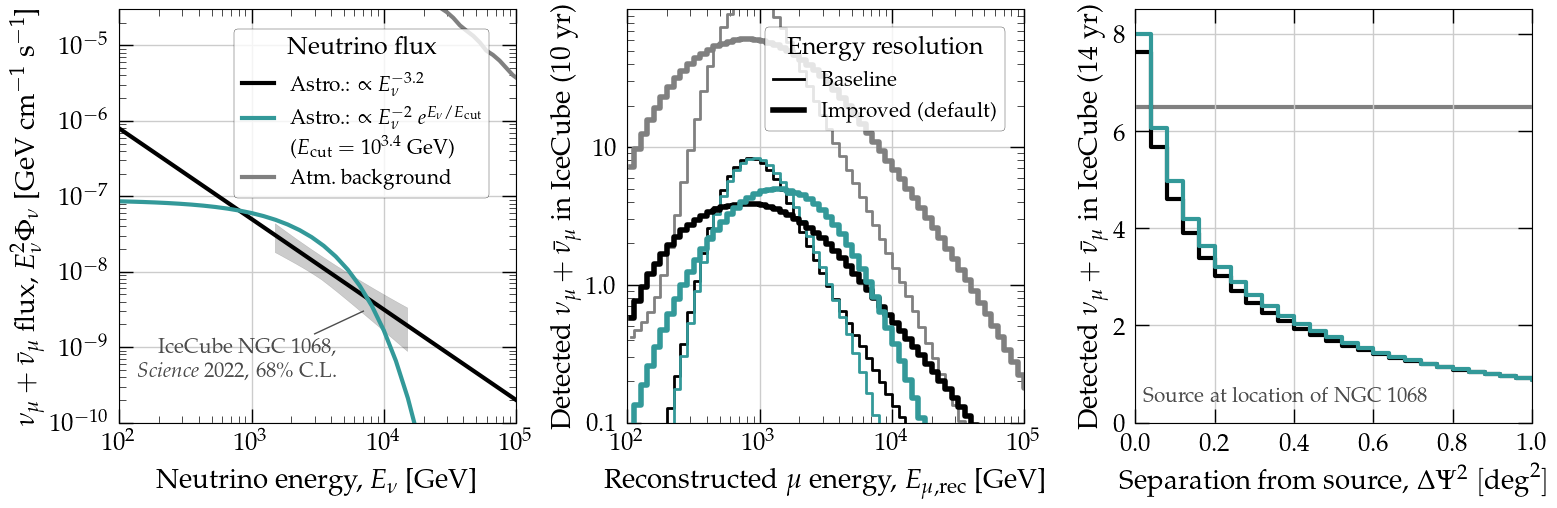

In [55]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2 # E**y_scaling on y axis

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
ax = axes[0]
fontsize = 20
# ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, st.E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
#     label=rf"Astro.: power law (PL) $\gamma=${st.GAMMA_NGC}",
    label=r"Astro.: $\propto E_\nu^{-3.2}$",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
#     label=rf"Astro.: PL $\gamma=${{{st.Gamma_cut:1.1f}}}"+"\n"
#     + rf"$\times$~cut-off ($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    label=r"\hspace*{-1.5em}Astro.: $\propto E_\nu^{-2}~e^{E_\nu/E_{\rm cut}}$"+r"\\[0.2em]"
    + rf"\hspace*{{-0.5em}}($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut}}}$ GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    10 ** st.logE_mids,
    local_background_flux * sq_deg * ((10 ** st.logE_mids) ** y_scaling),
#     label=r"Atmospheric background",
    label=r"Atm.~background",
    color="gray",
    lw=3,
)
# print(local_background_flux * sq_deg * ((10 ** st.logE_mids) ** y_scaling))

ax.set_yscale("log")
ax.set_ylabel(r"$\nu_\mu+\bar{\nu}_\mu$ flux,~$E_\nu^2 \Phi_\nu$ [GeV~cm$^{-1}$~s$^{-1}$]", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"Neutrino energy, $E_\nu$ [GeV]", fontsize=fontsize, labelpad=8)
ax.set_ylim(1e-10, 3e-5)
ax.set_xlim(1e2, 1e5)
f.legend(
    loc=3,
    frameon=True,
    bbox_to_anchor=(0.23, 0.565),
    title='Neutrino flux',
    title_fontsize=18,
    fontsize=15,
    edgecolor='k',
    handlelength=1.5
)
ax.annotate(r"IceCube NGC 1068,"+'\n'+r"{\it Science} 2022, 68\%~C.L.",
            xy=(0.55, 0.15),
            xycoords='axes fraction', 
            ha="right",
            va="center",
            zorder=10,
            color=font_color,
            fontsize=15)
ax.plot([3.e3, 7.e3], [1.5e-9, 3.e-9], c=font_color, lw=1, ls='-')


### plot Event numbers in E_reco
ii = 0
ax = axes[1]
ident = "IceCube"

for e_name in ["baseline", "improved"]:
    k_b = np.genfromtxt(join(st.BASEPATH, f"resources/background_events_{e_name}.txt"))
    k_s_pl = np.genfromtxt(join(st.BASEPATH, f"resources/PL_events_{e_name}.txt"))
    k_s_cut = np.genfromtxt(join(st.BASEPATH, f"resources/PLC_events_{e_name}.txt"))

    ax = axes[1]
    _label = e_name.capitalize()
    if e_name == "improved":
        _label += " (default)"
    ax.plot(
        10.**st.logE_reco_mids,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid",
        label=_label,
        color="k",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-",
    )

    ax.plot(
        10.**st.logE_reco_mids,
        k_s_cut.sum(axis=0),
        drawstyle="steps-mid",
        color="#339999",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-",
    )

    ax.plot(
        10.**st.logE_reco_mids,
        k_b.sum(axis=0),
        drawstyle="steps-mid",
        color="gray",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-",
    )
    print(rf"Number source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"Number atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
# ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1.e2, 1.e5)
ax.set_ylim(1.e-1, 10.e1)
ax.set_xlabel(r"Reconstructed~$\mu$ energy, $E_{\mu, {\rm rec}}$ [GeV]", fontsize=fontsize, labelpad=8)
ax.set_ylabel(r"Detected $\nu_\mu + \bar{\nu}_\mu$ in IceCube (10 yr)", fontsize=fontsize)
ax.set_yticks([0.1, 1.0, 10.], ['0.1', '1.0', '10'])
ax.legend(loc=3, 
          bbox_to_anchor=(0.32, 0.68),
          edgecolor='k',
          fontsize=15,
          title_fontsize=18,
          title=r'Energy resolution',
          handlelength=1.5)

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_cut.sum(axis=1)]),
    drawstyle="steps-mid",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    color="gray",
    lw=3,
    zorder=0,
)

ax.set_ylabel(r"Detected $\nu_\mu + \bar{\nu}_\mu$ in IceCube (14 yr)", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8.5)
ax.set_xlabel(r"Separation from source, $\Delta \Psi ^2~[{\rm deg}^2]$", fontsize=fontsize)
# ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)

ax.annotate(r"Source at location of NGC 1068",
            xy=(0.02, 0.06),
            xycoords='axes fraction', 
            ha="left",
            va="center",
            zorder=10,
            color=font_color,
            fontsize=15)


f.subplots_adjust(wspace=0.28)
f.savefig(
    join(st.BASEPATH, plot_path, "ngc_spectral_improved_dpsi.pdf"),
    bbox_inches="tight",
)

# Spectral models

In [47]:
gamma_err = 0.2
norm_err = 0.2

In [48]:
pvals_ngc = pd.read_pickle(
    join(st.BASEPATH, f"local/energy_cut_wiggle.pckl")
)
pvals_ngc["gamma_pl_diff"] = pvals_ngc.out_pl_gamma - st.GAMMA_NGC
pvals_ngc["norm_pl_diff"] = pvals_ngc.out_pl_norm - 1
pvals_ngc["pcheck_ratio"] = pvals_ngc.pval / pvals_ngc.pval_check

In [49]:
pivot_gamma_diff = pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", #"gamma_cut",
    values="gamma_pl_diff",
    #aggfunc="min",
)
pivot_norm_diff = pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", #"gamma_cut",
    values="norm_pl_diff",
    #aggfunc="min",
)

In [50]:
# parameter selection
baseline_selection = pvals_ngc.loc[
    (pvals_ngc.gamma_cut == 2)
    & np.isclose(pvals_ngc.normalization_factor, 1)
    & (pvals_ngc.logE_cut == 3.4)
]
print(baseline_selection)
flux_cut_norm = baseline_selection["flux_cut_norm"].values[0]

ngc_cut_flux = PLcut_flux(
    flux_cut_norm, st.Gamma_cut, st.logE_cut, st.E0_NGC, "powerlaw with cutoff"
)

   e_smearing          pval     pval_atmo    pval_check  significance  \
49   improved  2.031825e-11  2.031825e-11  2.031825e-11      6.601738   

    significance_atmo  significance_check  gamma_cut  logE_cut  flux_scaling  \
49          15.892544            6.601738          2       3.4      1.783528   

    flux_cut_norm  normalization_factor  out_pl_gamma  out_pl_norm  \
49   8.917642e-14                   1.0      3.132453     1.004353   

    out_plc_cut  out_plc_gamma  out_plc_norm  gamma_pl_diff  norm_pl_diff  \
49     3.400039       2.000037      1.783373      -0.067547      0.004353   

    pcheck_ratio  
49           1.0  


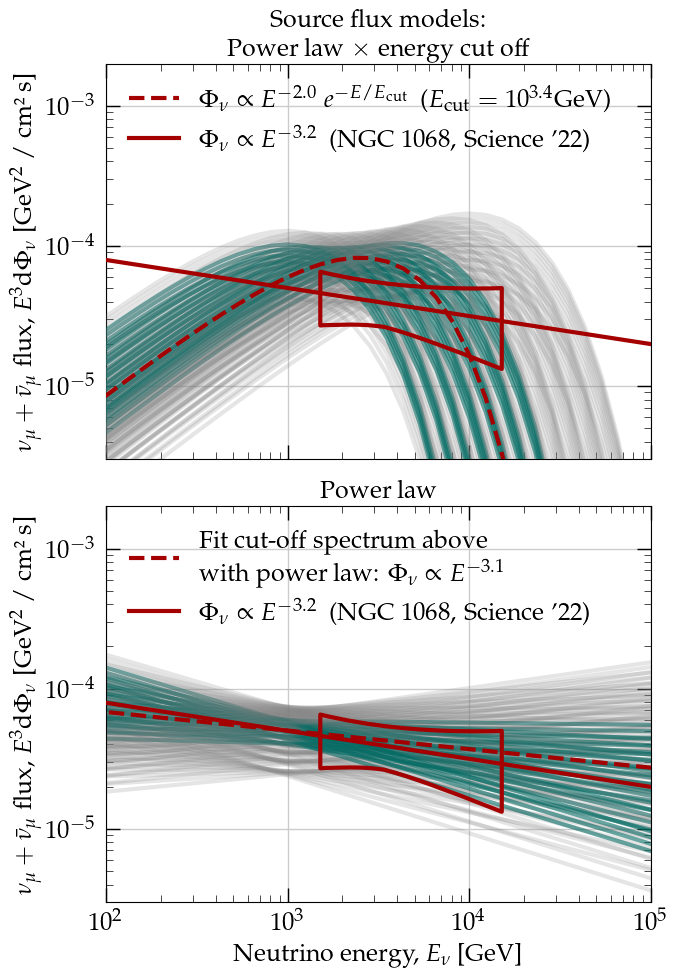

In [51]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy cut off")
ax[1].set_title("Power law")

current_color = st.colors[2]

tmp_Gamma_cut = 2
for (tmp_nz, tmp_logE_cut), series in pvals_ngc.groupby(
    ["normalization_factor", "logE_cut"]
):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[tmp_logE_cut].loc[tmp_nz]:
        alpha_val = 0.6
        col = current_color
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        series.iloc[0]["flux_cut_norm"],  # st.PHI_NGC * series.iloc[0]["flux_scaling"],
        tmp_Gamma_cut,
        tmp_logE_cut,
        st.E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=10,
        lw=3,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        st.PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        st.E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=1,
        lw=3,
    )
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax[0].plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"$\Phi_\nu \propto E^{{-{ngc_cut_flux.gamma}}} ~ e^{{-E/E_{{\rm cut}}}}$"
    + rf"~~($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
    # label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
    # + "\n"
    # + rf"$\times$ "
    # + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
)

# PL fit from chosen ecut/gamma parameters
tmp_ngc_flux = PL_flux(
    st.PHI_NGC * baseline_selection.iloc[0]["out_pl_norm"],
    baseline_selection.iloc[0]["out_pl_gamma"],
    st.E0_NGC,
    "powerlaw",
)

pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

ax[1].plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label="Fit cut-off spectrum above \n"
    + rf"with power law: $\Phi_\nu \propto E^{{-{tmp_ngc_flux.gamma:1.1f}}}$",
)


# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor=st.poles["Plenum-2"]["color"],
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"$\Phi_\nu \propto E^{{-{ngc_flux.gamma}}}$"
        + "~~(NGC 1068, Science '22)",
        color=st.poles["Plenum-2"]["color"],
        alpha=1,
        zorder=10,
        lw=3,
    )

    axx.set_yscale("log")
    axx.set_ylabel(
        r"$\nu_\mu+\bar{\nu}_\mu$ flux,~"
        + rf"$E^{{{y_scaling}}} {{\rm d}} \Phi_\nu$"  # / {{\rm d}}E$"
        + rf"~[GeV$^{{{y_scaling-1}}}$ / cm² s]",
    )
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 2e-3)
        axx.set_xlim(1e2, 1e5)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
        axx.set_xlim(1e2, 1e5)

    axx.legend(loc=2, frameon=False)
ax[1].set_xlabel(r"Neutrino energy, $E_{\nu}$ [GeV]")

f.tight_layout()
f.savefig(
    join(st.BASEPATH, plot_path, f"pl-cut_flux_model_matching_E{y_scaling}_noCM.pdf"),
    bbox_inches="tight",
)